In [ ]:
# import logging
# logging.basicConfig(filename='./test.log', level=logging.DEBUG, 
#                     format='%(asctime)s %(levelname)s %(name)s %(message)s')
# logger=logging.getLogger(__name__)

In [ ]:
# from IPython.core.magic import register_cell_magic

# @register_cell_magic('handle')
# def handle(line, cell):
#     try:
#         exec(cell)
#     except Exception as e:
#         logger.error(e)
#         raise # if you want the full trace-back in the notebook


# use %%handle when want to output error

# Co-training

For visualization of co-training process, we apply PCA to feature before training. This will make co-training process clear, but the result will be not accuracy because apply PCA will loss lots of information.

1. We assume only part of label exist

2. We only select binary case (Only when one name indicate two and only two author)

3. When we apply 10 fold with co-training, each fold of first iteration will be baseline compare to co-training

In [1]:
import os
import sys
import warnings

#warnings.filterwarnings('error')
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
np.set_printoptions(precision=4, suppress=True)

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import com_func

#----- threshold for selecting set of name group -----------#
threshold_select_name_group = 100
#----- threshold for selecting min sample in name group ----#
threshold_lower = 100
threshold_upper = 110

apply_threshold_to_name_group_samples = True

pp_text = ["pv_dbow"]
pp_citation = "n2v"

Dataset = "pubmed"

# Basic Co-training details
1. Basic co-training algorithm required parameter p,n,k,u. Since we have 15 different dataset, we will assume p and n is 1, k is 30. (We are simulate real world situation where we do not know the distribution of unlabeled data amount 15 different dataset)
2. We set the parameter u as size of input train data (labeled+unlabeled) since our ublabeled data is not that large.
3. During co-training process, the confidence measure is using probability as confident score to evaluate whether unlabel sample should be label or not, and which class belone to

In [2]:
import itertools
import warnings
import copy
import matplotlib.pyplot as plt
from adjustText import adjust_text
from sklearn.metrics import precision_score, recall_score,f1_score,accuracy_score

from collections import defaultdict

# create co training classifier
class Co_training_clf(object):
    
    def __init__(self, clf1, clf2=None, p=1, n=1, k=30, u = 75):
        
        self.clf1 = clf1
        # assume co_training on one classifier
        if clf2 == None:
            self.clf2 = copy.deepcopy(clf1)
        else:
            self.clf2 = clf2
        # take p example from most confidently positive labels to example
        self.p = p
        # take n example from most confidently negative label to example
        self.n = n
        # number of iteration
        self.k = k
        # size of pool of unlabeled samples
        self.u = u

    def softmax(self, x):
        """Compute softmax values for each sets of scores in x."""
        return np.exp(x) / np.sum(np.exp(x), axis=1)

    def sigmoid(self, x):
        return np.around(1 / (1 + np.exp(-x)), decimals=4).item()

    def init_L_U_U_prime(self, labels):
        # index of the samples that are initially labeled
        L = labels.index[labels != -1].tolist()
        # index of unlabeled samples
        U = labels.index[labels == -1].tolist()
        print("Initial L size: ", len(L))
        print("Initial U size: ", len(U))
        # random drawing sample from U
        random.shuffle(U)
        U_prime = U[-min(len(U), self.u):]
        # remove the samples in U_prime from U
        U = U[:-len(U_prime)]
        print("U size after drawing sample to U prime:",len(U))
        print("Initial U prime size: ", len(U_prime))
        return L, U, U_prime
    
    def check_iter_label_mapping(self, iter_clf1, iter_clf2):
        '''
        In theory, it shouldn't occur that label not mapping since it trained on same dataset but different view
        But add a check to make sure it won't occur and save the class mapping for later label unlabeled sample
        '''
        dv1_class_label = iter_clf1.classes_
        dv2_class_label = iter_clf2.classes_
        if all(dv1_class_label == dv2_class_label):
            self.classes_ = dv1_class_label
        else:
            sys.exit("Two view classifier label not mapping")

    def get_confidence_score(self, clf_h1, clf_h2, dv1, dv2):
        if hasattr(clf_h1, "predict_proba"):
            dv1_proba = clf_h1.predict_proba(dv1)
            dv2_proba = clf_h2.predict_proba(dv2)
        elif hasattr(clf_h1, "decision_function"):    # use decision function
            dv1_distance = np.array(clf_h1.decision_function(dv1))
            dv2_distance = np.array(clf_h2.decision_function(dv2))
            # if binary case, use sigmoid function to calculate probability
            if iter_train_label.nunique()==2:
                dv1_proba = []
                dv2_proba = []
                for distance in dv1_distance:
                    dv1_proba.append([1-self.sigmoid(distance), self.sigmoid(distance)])
                for distance in dv2_distance:
                    dv2_proba.append([1-self.sigmoid(distance), self.sigmoid(distance)])
            else:
                dv1_proba = self.softmax(dv1_distance)
                dv2_proba = self.softmax(dv2_distance)
            dv1_proba = np.array(dv1_proba)
            dv2_proba = np.array(dv2_proba)
            #print("Distance to hyperplane (dv1): ",dv1_distance)
            #print("Probability (dv1): ",dv1_proba)
        else:
            sys.exit("No confident score for process")
        
        return dv1_proba, dv2_proba

    def label_p_n_samples(self, proba, rank, proba_sample_idx_map):
        U_prime_size = len(proba)
        self_trained_sample_idx = []
        self_trained_confident = []
        for label, confident_rank in enumerate(rank):
            # 0 positive sample
            if label==0:
                p = []
                p_confident = []
                index = 0
                while(len(p) < self.p):
                    max_conf_sample_index = confident_rank[index]
                    # ---- if positive predict proba is more than 50% ------- #
                    if (proba[max_conf_sample_index][label] > 0.5):
                        #print('Sample idx: P: ', proba_sample_idx_map[max_conf_sample_index], " : ", proba[max_conf_sample_index])
                        p.append(proba_sample_idx_map[max_conf_sample_index])
                        p_confident.append(proba[max_conf_sample_index][label])
                    index +=1
                    if (index>=U_prime_size):
                        break
                self_trained_sample_idx.append(p)
                self_trained_confident.append(p_confident)
            # 1 negative sample
            elif label == 1:
                n = []
                n_confident = []
                index = 0
                while(len(n) < self.n):
                    max_conf_sample_index = confident_rank[index]
                    # ---- if negative predict proba is more than 50% ------- #
                    if (proba[max_conf_sample_index][label] > 0.5):
                        #print('Sample idx: N: ', proba_sample_idx_map[max_conf_sample_index], " : ", proba[max_conf_sample_index])
                        n.append(proba_sample_idx_map[max_conf_sample_index])
                        n_confident.append(proba[max_conf_sample_index][label])
                    index +=1
                    if (index>=U_prime_size):
                        break
                self_trained_sample_idx.append(n)
                self_trained_confident.append(n_confident)
            else:
                print("Class label error")
        return self_trained_sample_idx, self_trained_confident

    def get_self_labeled_sample(self):
        '''
        return:
            self-labeled new positive, self-labeled new negative (Index)
        '''
        
        return self.new_labeled_idx

    def plot_co_training_process(self, iterCount, data, iter_train_label, unlabeled_idx, h1_new = [], h2_new = [],
                                 h1_new_prob = [], h2_new_prob = [], plotSavingPath=None, name=None):
        if not os.path.exists(plotSavingPath):
            os.makedirs(plotSavingPath)
        pca_one = data[:,0]
        pca_two = data[:,1]
        # Layer 1. plot unlabel samples in u_prime
        fig, ax = plt.subplots(figsize=(9,7))
        ax.scatter(pca_one[unlabeled_idx], pca_two[unlabeled_idx], color='grey', label = "unlabeled", s = 50, alpha = 0.5)
        # Layer 2. plot the labeled samples
        for author in np.unique(iter_train_label):
            ix = iter_train_label.index[iter_train_label == author].tolist()
            # print(ix)
            ax.scatter(pca_one[ix], pca_two[ix], cmap='viridis', label = author, s = 50, alpha = 0.5)
        # layer 3. mark self labeled samples
        if iterCount != 0:
            all_h1_new = list(itertools.chain(*h1_new))
            all_h2_new = list(itertools.chain(*h2_new))
            temp_h1 = ax.scatter(pca_one[all_h1_new], pca_two[all_h1_new], edgecolor='black', linewidth=1, s=50)
            temp_h1.set_facecolor("none")
            temp_h1.set_label("h1 self-labeled")
            temp_h2 = ax.scatter(pca_one[all_h2_new], pca_two[all_h2_new], edgecolor='red', linewidth=1, s=50)
            temp_h2.set_facecolor("none")
            temp_h2.set_label("h2 self-labeled")
            # layer 4. mark new samples confidence and which view produce it
            last_iter_h1_new = h1_new[-1]
            last_iter_h2_new = h2_new[-1]
            last_iter_h1_new_prob = h1_new_prob[-1]
            last_iter_h2_new_prob = h2_new_prob[-1]
            text = []
            for i, idx in enumerate(last_iter_h1_new):
                text.append(plt.text(pca_one[idx], pca_two[idx], "{:.2f}".format(last_iter_h1_new_prob[i]), color='black'))
            for i, idx in enumerate(last_iter_h2_new):
                text.append(plt.text(pca_one[idx], pca_two[idx], "{:.2f}".format(last_iter_h2_new_prob[i]), color='red'))
            #print(text)
            adjust_text(text, x=pca_one, y=pca_two, force_points=0.3, force_text=0.3, expand_points=(2, 2), 
                        expand_text=(2, 2), arrowprops=dict(arrowstyle='Simple', color='red'))
        legend = ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=3,prop={'size': 13})
        plt.title('Co-training iteration: '+ str(iterCount), fontsize=14)
        plt.xlabel("First principal component",fontsize=14)
        plt.ylabel("Second principal component",fontsize=14)
        plt.savefig(fname=plotSavingPath+name+"_PCA_i-"+str(iterCount)+".png", dpi=100, bbox_extra_artists=(legend,), bbox_inches='tight')
        #plt.show()
        plt.close("all")
        

    def fit(self, dv1, dv2, labels, dv1_validation, dv2_validation, label_validation, dataset_name=None, plot_save_path=None):        
        # using all unlabeled sample instead of pool of unlabeled sample
        self.u = len(labels)
        # sync input datatype
        if not all(isinstance(i, pd.DataFrame) for i in [dv1, dv2, labels]):
            if not isinstance(dv1, pd.DataFrame):
                dv1 = pd.DataFrame(dv1)
            if not isinstance(dv2, pd.DataFrame):
                dv2 = pd.DataFrame(dv2)
            if not isinstance(labels, pd.DataFrame):
                labels = pd.DataFrame(labels, index = dv1.index.values)
        labels = pd.Series(labels[0].values, index=dv1.index.values) 
        
        L, U, U_prime = self.init_L_U_U_prime(labels)
        #print("All data index: ",dv1.index.values)
        #print("L: ", L)
        #print("U: ", U)
        #print("U_prime: ", U_prime)
        print("P value: ", self.p, " N value: ", self.n)
        
        # index of self labeled samples
        self.new_labeled_idx = defaultdict(list)
        self.h1_new_idx = defaultdict(list)
        self.h2_new_idx = defaultdict(list)
        # when fit co-train, we collect f1 on validation samples wrt each iteration
        self.f1_on_validation_dv1 = []
        self.f1_on_validation_dv2 = []
        
        self.iterCounter = 0
        # --------- plot PCA reduced plot for initial stage of train -------------- #
        init_train_label = labels[L]
        pca = PCA(n_components=2)
        '''Notice pca will change input datatype dataframe to datatype list, keep it's order,
           or re-assign dv1.index.values to the output'''
        pca_dv1 = pca.fit_transform(X=dv1)
        pca_dv2 = pca.fit_transform(X=dv2)
        if dataset_name != None:
            for pca_view,v_name in [(pca_dv1,"dv1"),(pca_dv2,"dv2")]:
                self.plot_co_training_process(self.iterCounter, pca_view, init_train_label, U_prime,
                                              plotSavingPath = plot_save_path, name = dataset_name+"_"+v_name)
        #loop until we have assigned labels to every sample in U and U_prime or we hit our iteration break condition
        while self.iterCounter < self.k and U_prime:
            '''
            Extract labeled training sample from training sample and train classifier, then make prediction
            Evaluate performance of current iteration classifier
            '''
            # print("Iteration:",self.iterCounter, " L: ",L)
            # print("Iteration:",self.iterCounter, " U_prime: ",U_prime)
            # ------------- get labeled samples for train ----------- # 
            iter_train_d1 = dv1.iloc[L]
            iter_train_d2 = dv2.iloc[L]
            iter_train_label = labels.iloc[L]
            # ----------- get U_prime unlabeled samples  ------------ #
            iter_unlabeled_d1 = dv1.iloc[U_prime]
            iter_unlabeled_d2 = dv2.iloc[U_prime]
            # ------------ train different view with classifier ----------- #
            iter_clf1 = copy.deepcopy(self.clf1) 
            iter_clf2 = copy.deepcopy(self.clf2)
            iter_clf1.fit(iter_train_d1, iter_train_label)
            iter_clf2.fit(iter_train_d2, iter_train_label)
            self.check_iter_label_mapping(iter_clf1, iter_clf2)
            # --------- test error on validation data --------------------- #
            # make prediction on validation data
            y1 = iter_clf1.predict(dv1_validation)
            y2 = iter_clf2.predict(dv2_validation)
            # f1 score on each iteration
            f1_dv1 = f1_dv2 = 0
            f1_dv1 = f1_score(label_validation, y1, average='macro')
            f1_dv2 = f1_score(label_validation, y2, average='macro')
            # collect f1 for current iteration
            self.f1_on_validation_dv1.append(f1_dv1)
            self.f1_on_validation_dv2.append(f1_dv2)
            ''' 
            Notice here dv1_proba and dv2_proba's index is index for u' (Unlabeled data only)
            We use index of u' to find index (position) of data in U where U and L is all data index
            '''
            # rank class probabilities for unlabeled sample for it's confidence measure
            dv1_proba, dv2_proba = self.get_confidence_score(clf_h1=iter_clf1, clf_h2=iter_clf2, 
                                                             dv1=iter_unlabeled_d1, dv2=iter_unlabeled_d2)
            proba_sample_idx_map = iter_unlabeled_d1.index
            dv1_proba_rank = []
            dv2_proba_rank = []
            # proba1_rank[i] is label i's confidence measure
            for class_proba in dv1_proba.T:
                dv1_proba_rank.append((-class_proba).argsort())
            for class_proba in dv2_proba.T:
                dv2_proba_rank.append((-class_proba).argsort())
            # print(dv1_proba)
            # print(dv1_proba_rank)
            # print(dv2_proba)
            # print(dv2_proba_rank)
            # h1 classifier self label data
            h1_new_sample, h1_new_sample_probs = self.label_p_n_samples(dv1_proba, dv1_proba_rank, proba_sample_idx_map)
            # h2 classifier
            h2_new_sample, h2_new_sample_probs = self.label_p_n_samples(dv2_proba, dv2_proba_rank, proba_sample_idx_map)
            
            # collect statistic for plot only (before remove self-labeled sample from u')
            iter_h1_for_plot = list(itertools.chain(*h1_new_sample))
            iter_h2_for_plot = list(itertools.chain(*h2_new_sample))
            iter_h1_prob = list(itertools.chain(*h1_new_sample_probs))
            iter_h2_prob = list(itertools.chain(*h2_new_sample_probs))
            self.h1_new_idx["index"].append(iter_h1_for_plot)
            self.h1_new_idx["confident"].append(iter_h1_prob)
            self.h2_new_idx["index"].append(iter_h2_for_plot)
            self.h2_new_idx["confident"].append(iter_h2_prob)
            '''
            Add most confidence samples as new training samples, auto label the samples and remove it from U_prime
            Special Case: if two view classifier give same most confident sample and p is 1, only 1 datapoint self-labeled
            '''
            roundNew = list(zip(h1_new_sample, h2_new_sample))
            roundNew_flatten_unique = []
            for label, round_new in enumerate(roundNew):
                round_new = set([item for sublist in round_new for item in sublist])
                round_new = [idx for idx in round_new]
                self.new_labeled_idx[self.classes_[label]].append(round_new)
                roundNew_flatten_unique.extend(round_new)
                # add label to those new samples
                #print(labels[round_new])
                labels[round_new] = self.classes_[label]
                #print(labels[round_new])
                #print(self.classes_[label]," (u' idx): ",round_new)
            #print(roundNew_flatten_unique)
            # extend the labeled sample
            L.extend(roundNew_flatten_unique)
            # remove the labeled sample from U_prime
            U_prime = [x for x in U_prime if x not in roundNew_flatten_unique]
            #print(U_prime)
            # randomly choice 2p+2n examples from u to replenish u_prime
            replenishItem = U[-(2*self.p+2*self.n):]
            U_prime.extend(replenishItem)
            U = U[:-len(replenishItem)]
            self.iterCounter +=1
            
            # ----------- plot the co-training process -------------- #
            if dataset_name != None:
                new_train_label = labels[L]
                # self_labeled_idx = [val for sublist in self_labeled_idx_temp for subsublist in sublist for val in subsublist]
                print("Iteration",self.iterCounter," h1 new: ", iter_h1_for_plot, " probs: ", iter_h1_prob)
                print("Iteration",self.iterCounter," h2 new: ", iter_h2_for_plot, " probs: ", iter_h2_prob)
                # ----- save pca reduced plot ------ #
                for pca_view,v_name in [(pca_dv1,"dv1"),(pca_dv2,"dv2")]:
                    self.plot_co_training_process(self.iterCounter, pca_view, new_train_label, U_prime,
                                                  self.h1_new_idx["index"], self.h2_new_idx["index"],
                                                  self.h1_new_idx["confident"], self.h2_new_idx["confident"],
                                                  plotSavingPath = plot_save_path, name = dataset_name+"_"+v_name)
            
        print("Total Labeled number: ", len(L), " Still unlabeled number: ", len(U_prime))
        #print(self.f1_on_validation_dv1)
        #print(self.f1_on_validation_dv2)
        # final train
        newtrain_d1 = dv1.iloc[L]
        newtrain_d2 = dv2.iloc[L]
        self.clf1.fit(newtrain_d1, labels.iloc[L])
        self.clf2.fit(newtrain_d2, labels.iloc[L])
        '''
        Evalutation plot for co-training process, save f1 score vs number of iteration plot
        '''
        if dataset_name != None:
            default_text_based = [self.f1_on_validation_dv1[0]] * self.iterCounter
            default_citation_based = [self.f1_on_validation_dv2[0]] * self.iterCounter
            default_step = np.arange(0,self.iterCounter)
            co_train_text_based = self.f1_on_validation_dv1[1:]
            co_train_citation_based = self.f1_on_validation_dv2[1:]
            co_training_step = np.arange(1,self.iterCounter)

            fig = plt.figure()
            ax = plt.axes()
            plt.plot(default_step, default_text_based, linestyle='dashed', label="Text based default")
            plt.plot(default_step, default_citation_based, linestyle='dashdot', label="Citation based default")
            plt.plot(co_training_step, co_train_text_based, linestyle='solid', marker = "*", label="Text based")
            plt.plot(co_training_step, co_train_citation_based, linestyle='dotted', marker = "+", label="Citation based")
            ax.autoscale_view()
            legend = ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=2)
            plt.xlabel('Co-Training Iterations')
            plt.ylabel('F1 score')
            plt.savefig((plot_save_path+dataset_name+"_co_train_iteration_f1.png"), dpi=150, bbox_extra_artists=(legend,), bbox_inches='tight')
            # plt.show()
            plt.close("all")
        return "Training Done"

    def co_train_process_f1(self):
        return self.f1_on_validation_dv1, self.f1_on_validation_dv2

    def get_iter_count(self):
        return self.iterCounter

    def predict(self, dv1, dv2):
        dv1_predict = self.clf1.predict(dv1)
        dv2_predict = self.clf2.predict(dv2)
        #fill pred with -1 so we can identify the samples in which error occur
        y_pred = ["-1"] * dv1.shape[0]
        for i, (dv1_y, dv2_y) in enumerate(zip(dv1_predict, dv2_predict)):
            # if both agree on label
            if dv1_y == dv2_y:
                y_pred[i] = dv1_y
            # If disagree on label and support proba method: We times probability together, choice class have higher probabilities
            elif hasattr(self.clf1, "predict_proba") and hasattr(self.clf2, "predict_proba"):
                h1_probas = self.clf1.predict_proba([dv1.iloc[i]])[0]
                h2_probas = self.clf2.predict_proba([dv2.iloc[i]])[0]
                final_y_probas = [proba_y1 * proba_y2 for (proba_y1, proba_y2) in zip(h1_probas, h2_probas)]
                #print("h1 and h2 disagree on",i, " h1 Proba : ",h1_probas, " h2 Proba: ", h2_probas)
                #print("product probas:",final_y_probas)
                max_prob_idx = final_y_probas.index(max(final_y_probas))
                y_pred[i] = self.classes_[max_prob_idx]
                #print("result idx: ", max_prob_idx, " result: ",y_pred[i])
            # If disagree on label and not support proba method: We use decision_function to first calculate probability,
            # then we times calculate probability together, choice class have higher probabilities
            elif hasattr(self.clf1, "decision_function") and hasattr(self.clf2, "decision_function"):
                dv1_distance = self.clf1.decision_function([dv1.iloc[i]])
                dv2_distance = self.clf2.decision_function([dv2.iloc[i]])
                if len(self.clf1.classes_)==2:
                    h1_probas = np.array([1-self.sigmoid(dv1_distance), self.sigmoid(dv1_distance)])
                    h2_probas = np.array([1-self.sigmoid(dv2_distance), self.sigmoid(dv2_distance)])
                else:
                    h1_probas = self.softmax(dv1_distance)
                    h2_probas = self.softmax(dv2_distance)
                final_y_probas = [proba_y1 * proba_y2 for (proba_y1, proba_y2) in zip(h1_probas, h2_probas)]
                #print("h1 and h2 disagree on",i, " h1 Proba : ",h1_probas, " h2 Proba: ", h2_probas)
                #print("product probas:",final_y_probas)
                max_prob_idx = final_y_probas.index(max(final_y_probas))
                y_pred[i] = self.classes_[max_prob_idx]
                #print("result idx: ", max_prob_idx, " result: ",y_pred[i])
            # disagree and not support any confidence measure
            else:
                sys.exit("Error occur")

        # convert final result to np array
        y_pred_np_array = np.asarray(y_pred)
        return y_pred_np_array

    def predict_proba(self, dv1, dv2):
        # the predicted probabilities is simply a product (*) of probabilities given from each classifier trained
        h1_probas = self.clf1.predict_proba(dv1)
        h2_probas = self.clf2.predict_proba(dv2)
        
        proba = (h1_probas*h2_probas)
        return proba


# Improved co-training

Possible improvement:

Part 1: Parameter input
1. Using two different algorithm for view one and view two.
2. Instead of using parameter k to control number of iteration, using a stop criterion where if unlabeled sample can't get more than 95% of confidence on their confidence score, then stop iteration and finish co-training.
3. Parameter p, n are not needed, use input data class ratio replace it (unlabeled distribution may different from labeled, this is unlikely works in reality).
4. u prime not needed, use all unlabeled data.

Part 2: Change confident measure method
1. Changes method used when determine which class unlabeled sample belones to, instead of using confident score, we could use classifiers saved during each iteration of training to perform an majority voting. (Need to careful about number of iteration in co-training, since adding bad unlabel data as label data is easy to occur) (Source: 2004_Co-training and Self-training for Word Sense Disambiguation)

Part 3: Change details in confident score method
1. Add an third classifier and only train with original labeled samples(no-self-labeled sample), then use third classifier to evaluate self-labeled samples and get it's confidence score. Combine three classifier's confidence score together to get final decision.
2. COTRADE method: construct undirected neighborhood graph using all samples, after finding most confident sample with it's corresponding class. Then, calculate distance between all labeled samples in this class and most confident sample in this class. This distance from graph + probability from supervised algorithm will be used together as confidence score.

Part 4: Add checking to reduce the chance of adding mislabeled data
1. Add an check on validation after new label sample is added, if not improving h1/h2, remove new labeled sample.

Part 5: Change algorithm and make it work for muti-class
1. Using same concept of muti-class SVM, train many OVR binary classifier. (To expensive)
2. Allow algorithm directly take muti-class case and using same concept as binary co-training.


My idea:
1. Use one classifier (check)
2. Have parameter k as default, but can be stoped early (check)
3. Parameter p, n are replace with sl_base which set as input data class ratio*sl_base. (Allow muti-class case and will maintaining the class distribution in L. However, unlabeled distribution may different from labeled, this is unlikely works in reality) (check)
4. u prime not needed, use all unlabeled data. (check)
5. Adopt smooth co-training method and add an evaluation to all classifier saved during smooth co-training. This evaluation will accumulate the probability of each past iteration as score (check)
6. Adopt COTRADE method, their assumption where that a correctly labeled example should be very close to samples in L with corresponding label same to be very useful. Thus a k-mean clustering is train with labeled, then transform unlabel data into same instance space as labeled, then calculate distance to each cluster's centroid, then use distance perfrom an softmax to get reverse of probability of sample belone to class. After that 1- reversed probability get probability and add it as part of co-train evaluation.
7. Beside smooth co-training and COTRADE method, we also check current iteration probability, if most confidence sample is less than 80% for both view, we stop iteration no matter what.

In [3]:
import itertools
import warnings
import copy
import matplotlib.pyplot as plt
from adjustText import adjust_text
from sklearn.cluster import KMeans
from sklearn.metrics import precision_score, recall_score,f1_score,accuracy_score

from collections import defaultdict

np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

# create co training classifier
class Improved_co_training_clf(object):
    
    def __init__(self, clf1, clf2=None, sl_total=2, k=30, **args):
        
        self.clf1 = clf1
        # assume co_training on one classifier
        if clf2 == None:
            self.clf2 = copy.deepcopy(clf1)
        else:
            self.clf2 = clf2
        # self-label step for each iteration
        if sl_total<2:
            sl_total = 2
        self.sl_total = sl_total
        self.iter_new_size =[]
        # number of iteration
        self.k = k

    def softmax(self, x):
        """Compute softmax values for each sets of scores in x."""
        return np.exp(x) / np.sum(np.exp(x), axis=0)

    def sigmoid(self, x):
        return np.around(1 / (1 + np.exp(-x)), decimals=4).item()

    def init_L_U_U_prime(self, labels):
        # index of the samples that are initially labeled
        L = labels.index[labels != -1].tolist()
        # index of unlabeled samples
        U = labels.index[labels == -1].tolist()
        print("Initial L size: ", len(L))
        print("Initial U size: ", len(U))
        # random drawing sample from U
        random.shuffle(U)
        U_prime = U[-min(len(U), self.u):]
        # remove the samples in U_prime from U
        U = U[:-len(U_prime)]
        print("U size after drawing sample to U prime:",len(U))
        print("Initial U prime size: ", len(U_prime))
        return L, U, U_prime
    
    def check_iter_label_mapping(self, iter_clf1, iter_clf2):
        '''
        In theory, it shouldn't occur that label not mapping since it trained on same dataset but different view
        But add a check to make sure it won't occur and save the class mapping for later label unlabeled sample
        '''
        dv1_class_label = iter_clf1.classes_
        dv2_class_label = iter_clf2.classes_
        if all(dv1_class_label == dv2_class_label):
            self.classes_ = dv1_class_label
        else:
            sys.exit("Two view classifier label not mapping")

    def get_confidence_score(self, clf_h1, clf_h2, dv1, dv2):
        if hasattr(clf_h1, "predict_proba"):
            dv1_proba = clf_h1.predict_proba(dv1)
            dv2_proba = clf_h2.predict_proba(dv2)
        elif hasattr(clf_h1, "decision_function"):    # use decision function
            dv1_distance = np.array(clf_h1.decision_function(dv1))
            dv2_distance = np.array(clf_h2.decision_function(dv2))
            # if binary case, use sigmoid function to calculate probability
            if iter_train_label.nunique()==2:
                dv1_proba = []
                dv2_proba = []
                for distance in dv1_distance:
                    dv1_proba.append([1-self.sigmoid(distance), self.sigmoid(distance)])
                for distance in dv2_distance:
                    dv2_proba.append([1-self.sigmoid(distance), self.sigmoid(distance)])
            else:
                dv1_proba = self.softmax(dv1_distance)
                dv2_proba = self.softmax(dv2_distance)
            dv1_proba = np.array(dv1_proba)
            dv2_proba = np.array(dv2_proba)
            #print("Distance to hyperplane (dv1): ",dv1_distance)
            #print("Probability (dv1): ",dv1_proba)
        else:
            sys.exit("No confident score for process")
        
        return dv1_proba, dv2_proba

    def get_cluster_distance_as_proba(self, label_train, iter_train_label, unlabeled):
        kmeans = KMeans(n_clusters=len(self.classes_)).fit(label_train)
        # map correct idx to label
        kmeans_predict = kmeans.labels_
        label_mapping = list(zip(iter_train_label, kmeans_predict))
        lmc = Counter(label_mapping)
        final_label_mapping = []
        for label in np.unique(iter_train_label):
            for (item,index),count in lmc.most_common():
                if item == label:
                    #print("label:",label, " idx:",index, " count:",count)
                    final_label_mapping.append((item,index))
                    break
        #print(final_label_mapping)
        
        # convert distance to centroid to probability of belone to class
        dist_to_centroid = kmeans.transform(unlabeled)
        cluster_proba = []
        for distance in dist_to_centroid:
            reverse_proba = self.softmax(distance)
            proba = [1-x for x in reverse_proba]
            cluster_proba.append(proba)
        cluster_proba = np.array(cluster_proba)
        
        # map the proba same order as train in supervised learning
        new_permutation = [idx for label, idx in final_label_mapping]
        #print(new_permutation)
        idx = np.empty_like(new_permutation)
        idx[new_permutation] = np.arange(len(new_permutation))
        cluster_proba[:] = cluster_proba[:, idx]
        
        return cluster_proba

    def label_samples(self, score, rank, score_sample_idx_map,curr_iter_proba):
        U_prime_size = len(score)
        self_trained_sample_idx = []
        self_trained_confident = []
        self_trained_iter_proba = []
        for label, confident_rank in enumerate(rank):
            new_label_sample_size = [size for item,size in self.iter_new_size if self.classes_[label] in item][0]
            new_sample_idx = []
            new_sample_confident_score = []
            new_sample_proba = []
            index = 0
            while(len(new_sample_idx) < new_label_sample_size):
                max_conf_sample_index = confident_rank[index]
                if curr_iter_proba[max_conf_sample_index][label]<0.8:
                    #print('Most confident idx: ', max_conf_sample_index,":",score_sample_idx_map[max_conf_sample_index]," have score: ",score[max_conf_sample_index], "have probability ",curr_iter_proba[max_conf_sample_index], " less than 0.8 thus not used")
                    index +=1
                else:
                    #print('Class:', self.classes_[label],' idx: ',max_conf_sample_index,":",score_sample_idx_map[max_conf_sample_index], " score: ", score[max_conf_sample_index], " iter proba: ", curr_iter_proba[max_conf_sample_index])
                    new_sample_idx.append(score_sample_idx_map[max_conf_sample_index])
                    new_sample_confident_score.append(score[max_conf_sample_index][label])
                    new_sample_proba.append(curr_iter_proba[max_conf_sample_index][label])
                    index +=1
                if (index>=U_prime_size) :
                    break
            self_trained_sample_idx.append(new_sample_idx)
            self_trained_confident.append(new_sample_confident_score)
            self_trained_iter_proba.append(new_sample_proba)
        return self_trained_sample_idx, self_trained_confident, self_trained_iter_proba

    def get_self_labeled_sample(self):
        '''
        return:
            self-labeled new positive, self-labeled new negative (Index)
        '''
        
        return self.new_labeled_idx

    def plot_co_training_process(self, iterCount, data, iter_train_label, unlabeled_idx, h1_new = [], h2_new = [],
                                 h1_new_prob = [], h2_new_prob = [], plotSavingPath=None, name=None):
        if not os.path.exists(plotSavingPath):
            os.makedirs(plotSavingPath)
        pca_one = data[:,0]
        pca_two = data[:,1]
        # Layer 1. plot unlabel samples in u_prime
        fig, ax = plt.subplots(figsize=(9,7))
        ax.scatter(pca_one[unlabeled_idx], pca_two[unlabeled_idx], color='grey', label = "unlabeled", s = 50, alpha = 0.5)
        # Layer 2. plot the labeled samples
        for author in np.unique(iter_train_label):
            ix = iter_train_label.index[iter_train_label == author].tolist()
            # print(ix)
            ax.scatter(pca_one[ix], pca_two[ix], cmap='viridis', label = author, s = 50, alpha = 0.5)
        # layer 3. mark self labeled samples
        if iterCount != 0:
            all_h1_new = list(itertools.chain(*h1_new))
            all_h2_new = list(itertools.chain(*h2_new))
            temp_h1 = ax.scatter(pca_one[all_h1_new], pca_two[all_h1_new], edgecolor='black', linewidth=1, s=50)
            temp_h1.set_facecolor("none")
            temp_h1.set_label("h1 self-labeled")
            temp_h2 = ax.scatter(pca_one[all_h2_new], pca_two[all_h2_new], edgecolor='red', linewidth=1, s=50)
            temp_h2.set_facecolor("none")
            temp_h2.set_label("h2 self-labeled")
            # layer 4. mark new samples confidence and which view produce it
            last_iter_h1_new = h1_new[-1]
            last_iter_h2_new = h2_new[-1]
            last_iter_h1_new_prob = h1_new_prob[-1]
            last_iter_h2_new_prob = h2_new_prob[-1]
            text = []
            for i, idx in enumerate(last_iter_h1_new):
                text.append(plt.text(pca_one[idx], pca_two[idx], "{:.2f}".format(last_iter_h1_new_prob[i]), color='black'))
            for i, idx in enumerate(last_iter_h2_new):
                text.append(plt.text(pca_one[idx], pca_two[idx], "{:.2f}".format(last_iter_h2_new_prob[i]), color='red'))
            adjust_text(text, x=pca_one, y=pca_two, force_points=0.3, force_text=0.3, expand_points=(2, 2), 
                        expand_text=(2, 2), arrowprops=dict(arrowstyle='Simple', color='red'))
        legend = ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=3,prop={'size': 13})
        plt.title('Co-training iteration: '+ str(iterCount), fontsize=14)
        plt.xlabel("First principal component",fontsize=14)
        plt.ylabel("Second principal component",fontsize=14)
        plt.savefig(fname=plotSavingPath+name+"_PCA_i-"+str(iterCount)+".png", dpi=100, bbox_extra_artists=(legend,), bbox_inches='tight')
        # plt.show()
        plt.close("all")
        

    def fit(self, dv1, dv2, labels, dv1_validation, dv2_validation, label_validation, dataset_name=None, plot_save_path=None):        
        # using all unlabeled sample instead of pool of unlabeled sample
        self.u = len(labels)
        # sync input datatype
        if not all(isinstance(i, pd.DataFrame) for i in [dv1, dv2, labels]):
            if not isinstance(dv1, pd.DataFrame):
                dv1 = pd.DataFrame(dv1)
            if not isinstance(dv2, pd.DataFrame):
                dv2 = pd.DataFrame(dv2)
            if not isinstance(labels, pd.DataFrame):
                labels = pd.DataFrame(labels, index = dv1.index.values)
        labels = pd.Series(labels[0].values, index=dv1.index.values) 
        
        L, U, U_prime = self.init_L_U_U_prime(labels)
        #print("All data index: ",dv1.index.values)
        #print("L: ", L)
        #print("U: ", U)
        #print("U_prime: ", U_prime)
        
        # get class ratio
        c = Counter(labels)
        class_ratio = [(i, c[i] / (len(L))) for i in c if i != -1]
        for label, ratio in class_ratio:
            self.iter_new_size.append((label,np.ceil(self.sl_total*ratio)))
        print(self.iter_new_size)
        
        # index of self labeled samples
        self.new_labeled_idx = defaultdict(list)
        self.h1_new_idx = defaultdict(list)
        self.h2_new_idx = defaultdict(list)
        # save clf in each iteration
        self.iter_clf = []
        # when fit co-train, we collect f1 on validation samples wrt each iteration
        self.f1_on_validation_dv1 = []
        self.f1_on_validation_dv2 = []
        
        self.iterCounter = 0
        # --------- plot PCA reduced plot for initial stage of train -------------- #
        init_train_label = labels[L]
        pca = PCA(n_components=2)
        '''Notice pca will change input datatype dataframe to datatype list, keep it's order,
           or re-assign dv1.index.values to the output'''
        pca_dv1 = pca.fit_transform(X=dv1)
        pca_dv2 = pca.fit_transform(X=dv2)
        if dataset_name != None:
            for pca_view,v_name in [(pca_dv1,"dv1"),(pca_dv2,"dv2")]:
                self.plot_co_training_process(self.iterCounter, pca_view, init_train_label, U_prime,
                                              plotSavingPath = plot_save_path, name = dataset_name+"_"+v_name)
        #loop until we have assigned labels to every sample in U and U_prime or we hit our iteration break condition
        while self.iterCounter < self.k and U_prime:
            '''
            Extract labeled training sample from training sample and train classifier, then make prediction
            Evaluate performance of current iteration classifier
            '''
            # print("Iteration:",self.iterCounter, " L: ",L)
            # print("Iteration:",self.iterCounter, " U_prime: ",U_prime)
            # get labeled samples and their label
            iter_train_d1 = dv1.iloc[L]
            iter_train_d2 = dv2.iloc[L]
            iter_train_label = labels.iloc[L]
            # get U_prime unlabeled samples
            iter_unlabeled_d1 = dv1.iloc[U_prime]
            iter_unlabeled_d2 = dv2.iloc[U_prime]
            # ------------ train different view with classifier ----------- #
            iter_clf1 = copy.deepcopy(self.clf1) 
            iter_clf2 = copy.deepcopy(self.clf2)
            iter_clf1.fit(iter_train_d1, iter_train_label)
            iter_clf2.fit(iter_train_d2, iter_train_label)
            self.check_iter_label_mapping(iter_clf1, iter_clf2)
            # --------- test error on validation data --------------------- #
            # make prediction on validation data
            y1 = iter_clf1.predict(dv1_validation)
            y2 = iter_clf2.predict(dv2_validation)
            # f1 score on each iteration
            f1_dv1 = f1_dv2 = 0
            f1_dv1 = f1_score(label_validation, y1, average='macro')
            f1_dv2 = f1_score(label_validation, y2, average='macro')
            
            # collect f1 for current iteration
            self.f1_on_validation_dv1.append(f1_dv1)
            self.f1_on_validation_dv2.append(f1_dv2)
            self.iter_clf.append((self.iterCounter,iter_clf1,iter_clf2))
            ''' 
            Confidence measure:
            Part 1: Accumulate predicted probability on each iteration as score
            Case 1: Two view agree with large confidence score
            Case 2: Two view disagree, but one have large confidence socre
            Case 3: Two view disagree and both have large confidence socre
            Case 4: Two view agree/disagree with small confidence score
            For case 1,2,3, add it's score to final proba for rank and this accumulation of score show smooth problem 
            created by case 2 and 3. 
            For case 4, give score [0,0] to final proba for this iteration since clf not confident on this sample
            '''
            dv1_diff_iter_score = []
            dv2_diff_iter_score = []
            for iteration, h1_clf, h2_clf in self.iter_clf:
                iter_dv1_proba, iter_dv2_proba = self.get_confidence_score(clf_h1=h1_clf, clf_h2=h2_clf, 
                                                                           dv1=iter_unlabeled_d1, dv2=iter_unlabeled_d2)
                dv1_diff_iter_score.append(iter_dv1_proba)
                dv2_diff_iter_score.append(iter_dv2_proba)
            curr_iter_dv1_score = dv1_diff_iter_score[-1]
            curr_iter_dv2_score = dv2_diff_iter_score[-1]
            # add score in each iteration
            dv1_final_score = np.array([sum(x) for x in zip(*dv1_diff_iter_score)])
            dv2_final_score = np.array([sum(x) for x in zip(*dv2_diff_iter_score)])
            '''
            Part 2: Incorporate clustering distance as part of score
            '''
            dv1_cluster_proba = self.get_cluster_distance_as_proba(label_train=iter_train_d1, iter_train_label=iter_train_label,
                                                                   unlabeled=iter_unlabeled_d1)
            dv2_cluster_proba = self.get_cluster_distance_as_proba(label_train=iter_train_d2, iter_train_label=iter_train_label,
                                                                   unlabeled=iter_unlabeled_d2)
            dv1_final_score = np.array([sum(x) for x in zip(dv1_final_score,dv1_cluster_proba)])
            dv2_final_score = np.array([sum(x) for x in zip(dv2_final_score,dv2_cluster_proba)])
            '''
            Part 3: Rank confidence and start self labeling
            '''
            proba_sample_idx_map=iter_unlabeled_d1.index
            dv1_proba_rank = []
            dv2_proba_rank = []
            # proba1_rank[i] is label i's confidence measure
            for class_proba in dv1_final_score.T:
                dv1_proba_rank.append((-class_proba).argsort())
            for class_proba in dv2_final_score.T:
                dv2_proba_rank.append((-class_proba).argsort())
            #print(dv1_final_score)
            #print(dv1_proba_rank)
            #print(dv2_final_score)
            #print(dv2_proba_rank)
            # h1 classifier self label data
            h1_new_sample, h1_new_sample_score, h1_new_sample_proba = self.label_samples(dv1_final_score, 
                                                                                         dv1_proba_rank, 
                                                                                         proba_sample_idx_map, 
                                                                                         curr_iter_dv1_score)
            # h2 classifier
            h2_new_sample, h2_new_sample_score, h2_new_sample_proba = self.label_samples(dv2_final_score, 
                                                                                         dv2_proba_rank, 
                                                                                         proba_sample_idx_map, 
                                                                                         curr_iter_dv2_score)
            # collect statistic for plot only (before remove self-labeled sample from u')
            iter_h1_new_idx = list(itertools.chain(*h1_new_sample))
            iter_h2_new_idx = list(itertools.chain(*h2_new_sample))
            # if no new label added to L, stop iteration
            if (len(iter_h1_new_idx)==0) and (len(iter_h2_new_idx)==0):
                self.iterCounter += 1
                print("Remaining unlabel sample is uncertain.")
                break
            iter_h1_score= list(itertools.chain(*h1_new_sample_score))
            iter_h2_score = list(itertools.chain(*h2_new_sample_score))
            iter_h1_proba= list(itertools.chain(*h1_new_sample_proba))
            iter_h2_proba = list(itertools.chain(*h2_new_sample_proba))
            self.h1_new_idx["index"].append(iter_h1_new_idx)
            self.h1_new_idx["score"].append(iter_h1_score)
            self.h1_new_idx["last_iter_proba"].append(iter_h1_proba)
            self.h2_new_idx["index"].append(iter_h2_new_idx)
            self.h2_new_idx["score"].append(iter_h2_score)
            self.h2_new_idx["last_iter_proba"].append(iter_h2_proba)
            '''
            Add most confidence samples as new training samples, auto label the samples and remove it from U_prime
            Special Case: if two view classifier give same most confident sample, only 1 datapoint self-labeled
            '''
            roundNew = list(zip(h1_new_sample, h2_new_sample))
            roundNew_flatten_unique = []
            for label, round_new in enumerate(roundNew):
                round_new = set([item for sublist in round_new for item in sublist])
                round_new = [idx for idx in round_new]
                self.new_labeled_idx[self.classes_[label]].append(round_new)
                roundNew_flatten_unique.extend(round_new)
                # add label to those new samples
                #print(labels[round_new])
                labels[round_new] = self.classes_[label]
                #print(labels[round_new])
                #print(self.classes_[label]," (u' idx): ",round_new)
            #print(roundNew_flatten_unique)
            # extend the labeled sample
            L.extend(roundNew_flatten_unique)
            # remove the labeled sample from U_prime
            U_prime = [x for x in U_prime if x not in roundNew_flatten_unique]
            #print(U_prime)
            # randomly choice 2p+2n examples from u to replenish u_prime
            replenishItem = U[-(self.sl_total):]
            U_prime.extend(replenishItem)
            U = U[:-len(replenishItem)]
            self.iterCounter +=1
            
            # ----------- plot the co-training process -------------- #
            if dataset_name != None:
                new_train_label = labels[L]
                # self_labeled_idx = [val for sublist in self_labeled_idx_temp for subsublist in sublist for val in subsublist]
                print("Iteration",self.iterCounter," h1 new: ", iter_h1_new_idx, " score: ", iter_h1_score)
                print("Iteration",self.iterCounter," h2 new: ", iter_h2_new_idx, " score: ", iter_h2_score)
                # ----- save pca reduced plot ------ #
                for pca_view,v_name in [(pca_dv1,"dv1"),(pca_dv2,"dv2")]:
                    self.plot_co_training_process(self.iterCounter, pca_view, new_train_label, U_prime,
                                                  self.h1_new_idx["index"], self.h2_new_idx["index"],
                                                  self.h1_new_idx["last_iter_proba"], self.h2_new_idx["last_iter_proba"],
                                                  plotSavingPath = plot_save_path, name = dataset_name+"_"+v_name)
            
        print("Total Labeled number: ", len(L), " Still unlabeled number: ", len(U_prime))
        #print(self.f1_on_validation_dv1)
        #print(self.f1_on_validation_dv2)
        # final train
        newtrain_d1 = dv1.iloc[L]
        newtrain_d2 = dv2.iloc[L]
        self.clf1.fit(newtrain_d1, labels.iloc[L])
        self.clf2.fit(newtrain_d2, labels.iloc[L])
        '''
        Evalutation plot for co-training process, save f1 score vs number of iteration plot
        '''
        if dataset_name != None:
            default_text_based = [self.f1_on_validation_dv1[0]] * self.iterCounter
            default_citation_based = [self.f1_on_validation_dv2[0]] * self.iterCounter
            default_step = np.arange(0,self.iterCounter)
            co_train_text_based = self.f1_on_validation_dv1[1:]
            co_train_citation_based = self.f1_on_validation_dv2[1:]
            co_training_step = np.arange(1,self.iterCounter)

            fig = plt.figure()
            ax = plt.axes()
            plt.plot(default_step, default_text_based, linestyle='dashed', label="Text based default")
            plt.plot(default_step, default_citation_based, linestyle='dashdot', label="Citation based default")
            plt.plot(co_training_step, co_train_text_based, linestyle='solid', marker = "*", label="Text based")
            plt.plot(co_training_step, co_train_citation_based, linestyle='dotted', marker = "+", label="Citation based")
            ax.autoscale_view()
            legend = ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=2)
            plt.xlabel('Co-Training Iterations')
            plt.ylabel('F1 score')
            plt.savefig((plot_save_path+dataset_name+"_co_train_iteration_f1.png"), dpi=150, bbox_extra_artists=(legend,), bbox_inches='tight')
            # plt.show()
            plt.close("all")
        return "Training Done"

    def co_train_process_f1(self):
        return self.f1_on_validation_dv1, self.f1_on_validation_dv2

    def get_iter_count(self):
        return self.iterCounter

    def predict(self, dv1, dv2):
        dv1_predict = self.clf1.predict(dv1)
        dv2_predict = self.clf2.predict(dv2)
        #fill pred with -1 so we can identify the samples in which error occur
        y_pred = ["-1"] * dv1.shape[0]
        for i, (dv1_y, dv2_y) in enumerate(zip(dv1_predict, dv2_predict)):
            # if both agree on label
            if dv1_y == dv2_y:
                y_pred[i] = dv1_y
            # If disagree on label and support proba method: We times probability together, choice class have higher probabilities
            elif hasattr(self.clf1, "predict_proba") and hasattr(self.clf2, "predict_proba"):
                h1_probas = self.clf1.predict_proba([dv1.iloc[i]])[0]
                h2_probas = self.clf2.predict_proba([dv2.iloc[i]])[0]
                final_y_probas = [proba_y1 * proba_y2 for (proba_y1, proba_y2) in zip(h1_probas, h2_probas)]
                #print("h1 and h2 disagree on",i, " h1 Proba : ",h1_probas, " h2 Proba: ", h2_probas)
                #print("product probas:",final_y_probas)
                max_prob_idx = final_y_probas.index(max(final_y_probas))
                y_pred[i] = self.classes_[max_prob_idx]
                #print("result idx: ", max_prob_idx, " result: ",y_pred[i])
            # If disagree on label and not support proba method: We use decision_function to first calculate probability,
            # then we times calculate probability together, choice class have higher probabilities
            elif hasattr(self.clf1, "decision_function") and hasattr(self.clf2, "decision_function"):
                dv1_distance = self.clf1.decision_function([dv1.iloc[i]])
                dv2_distance = self.clf2.decision_function([dv2.iloc[i]])
                if len(self.clf1.classes_)==2:
                    h1_probas = np.array([1-self.sigmoid(dv1_distance), self.sigmoid(dv1_distance)])
                    h2_probas = np.array([1-self.sigmoid(dv2_distance), self.sigmoid(dv2_distance)])
                else:
                    h1_probas = self.softmax(dv1_distance)
                    h2_probas = self.softmax(dv2_distance)
                final_y_probas = [proba_y1 * proba_y2 for (proba_y1, proba_y2) in zip(h1_probas, h2_probas)]
                #print("h1 and h2 disagree on",i, " h1 Proba : ",h1_probas, " h2 Proba: ", h2_probas)
                #print("product probas:",final_y_probas)
                max_prob_idx = final_y_probas.index(max(final_y_probas))
                y_pred[i] = self.classes_[max_prob_idx]
                #print("result idx: ", max_prob_idx, " result: ",y_pred[i])
            # disagree and not support any confidence measure
            else:
                sys.exit("Error occur")

        # convert final result to np array
        y_pred_np_array = np.asarray(y_pred)
        return y_pred_np_array

    def predict_proba(self, dv1, dv2):
        # the predicted probabilities is simply a product (*) of probabilities given from each classifier trained
        h1_probas = self.clf1.predict_proba(dv1)
        h2_probas = self.clf2.predict_proba(dv2)
        
        proba = (h1_probas*h2_probas)
        return proba


In [ ]:
import copy
import random
import collections

import seaborn as sns

from collections import Counter
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score,f1_score,accuracy_score

# cross validation
def k_fold_cv_all_algorithm(dv1, dv2, label, init_labeled_size, muti_view_clf=[], combined_clf=[],
                            num_fold=10, dataset_name=None, plot_save_path=None, validation=True):
    # set validation dataset as 10% of all data
    if validation:
        init_validation_size = len(label)*0.1
    else:
        init_validation_size = 0
    kf = StratifiedKFold(n_splits=num_fold)
    allTrueLabel = []
    co_train_algorithm = [name for clf,name in muti_view_clf]
    baseline_algorithm = [name for clf,name in combined_clf]
    allPredLabel = collections.defaultdict(list)
    all_fold_coTrain_diff_iteration = collections.defaultdict(list)
    co_train_iteration = collections.defaultdict(list)
    
    all_fold_statistic = []
    fold = 0
    # convert different input type to dataframe for consistency
    dv1 = pd.DataFrame(dv1)
    dv2 = pd.DataFrame(dv2)
    
    for train_index, test_index in kf.split(dv1, label):
        fold +=1
        # print("TRAIN:", train_index, " \n TEST:", test_index)
        # ---------------split train and test -------------------- #
        dv1_train, dv1_test = dv1.iloc[train_index], dv1.iloc[test_index]
        dv2_train, dv2_test = dv2.iloc[train_index], dv2.iloc[test_index]
        all_label_train, label_test = label.iloc[train_index], label.iloc[test_index]
        
        # -------plot true labeled result for different view on each fold ------- #
        '''Only for visualization of co-training process, use PCA to reduce views to 2d
           Real training process will not using PCA to reduce it's dimension '''
        detailed_plot_path = plot_save_path+dataset_name+"/fold"+str(fold)+"/"
        if not os.path.exists(detailed_plot_path):
            os.makedirs(detailed_plot_path)
        # 1. apply PCA to different views
        pca = PCA(n_components=2)
        for view,name in [(dv1,"dv1"),(dv2,"dv2")]:
            pca_view = pca.fit_transform(X=view)
            first_principal_component = pca_view[:,0]
            second_principal_component = pca_view[:,1]
            fig, ax = plt.subplots(figsize=(9,7))
            for author in np.unique(label):
                ix = label.index[label == author].tolist()
                ax.scatter(x=first_principal_component[ix], y=second_principal_component[ix],
                           cmap='viridis', label = author, s = 50, alpha = 0.5)
            legend = ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=2,prop={'size': 13})
            plt.title('True label', fontsize=14)
            plt.xlabel("First principal component",fontsize=14)
            plt.ylabel("Second principal component",fontsize=14)
            plt.savefig(fname=detailed_plot_path+dataset_name+"_PCA_true_label_"+name+".png",
                        dpi=100, bbox_extra_artists=(legend,), bbox_inches='tight')
            #plt.show()
            plt.close("all")

        # ----------- set some labeled data as unlabeled ------------ #
        # 1. obtain data ratio
        c = Counter(all_label_train)
        data_ratio = [(i, c[i] / len(all_label_train)) for i in c]
        print(data_ratio)
        # 2. calculate per class size 
        # co_train_per_class_size contain (label,initial train size for each class, initial validation data for each class)
        co_train_per_class_size = [(label, round(ratio*init_labeled_size),round(ratio*init_validation_size)) for label, ratio in data_ratio]
        print(co_train_per_class_size)
        # 3.Initialize train and validation sample index list save it for later use
        temp_train_label = all_label_train.tolist()
        train_sample_idx = []
        validation_sample_idx = []
        # 4. random draw both train labeled samples and validation samples, mark other as unlabeled
        # we could also use validation samples to improve performance
        for unique_label, training_size, validation_size in co_train_per_class_size:
            curr_label_idx = [i for i, x in enumerate(temp_train_label) if x == unique_label]
            curr_label_size = len(curr_label_idx)
            # 1. get train sample idx
            temp_train_sample_idx = random.sample(curr_label_idx, training_size)
            train_sample_idx += temp_train_sample_idx
            curr_label_idx_no_train = [x for x in curr_label_idx if x not in temp_train_sample_idx]
            # 2. get validation sample idx
            temp_validation_sample_idx = random.sample(curr_label_idx_no_train, validation_size)
            validation_sample_idx += temp_validation_sample_idx
            # 3. set other samples to -1 as unlabeled
            unlabel_item_idx = [x for x in curr_label_idx_no_train if x not in temp_validation_sample_idx]
            for unlabel_idx in unlabel_item_idx:
                temp_train_label[unlabel_idx]=-1

        #print(temp_train_label)
        ''' Case 1: Using validation dataset for each fold of train
            Case 2: Not Using validation dataset for each fold of train'''
        # collect per fold statistic
        curr_fold_statistic = {'author': dataset_name, 'fold':fold, 'train_size': len(train_sample_idx),
                               'validation_size':len(validation_sample_idx), 'test_size': dv1_test.shape[0]} 
        for in_clf, clf_name in muti_view_clf: 
            per_clf_plot_save_path = detailed_plot_path+clf_name+"/"
            if not os.path.exists(per_clf_plot_save_path):
                os.makedirs(per_clf_plot_save_path)
            if validation:
                unlabeled_sample_size = len(temp_train_label)-len(train_sample_idx)-len(validation_sample_idx)
                # extract validation data
                dv1_validation = dv1_train.iloc[validation_sample_idx,:]
                dv2_validation = dv2_train.iloc[validation_sample_idx,:]
                validation_label = [temp_train_label[idx] for idx in validation_sample_idx]
                # use other data as train
                final_dv1_train = dv1_train[~dv1_train.isin(dv1_validation)].dropna(axis=0, how="all").reset_index(drop=True)
                final_dv2_train = dv2_train[~dv2_train.isin(dv2_validation)].dropna(axis=0, how="all").reset_index(drop=True)
                final_train_label = [x for i, x in enumerate(temp_train_label) if i not in validation_sample_idx]
                # check data sync
                # print(validation_label)
                # print(all_label_train[dv1_validation.index])
                per_fold_clf = copy.deepcopy(in_clf)
                per_fold_clf.fit(dv1=final_dv1_train, dv2=final_dv2_train, labels=final_train_label, 
                                 dv1_validation=dv1_validation, dv2_validation=dv2_validation, label_validation=validation_label,
                                 dataset_name=dataset_name, plot_save_path=per_clf_plot_save_path)
            else:
                unlabeled_sample_size = len(temp_train_label)-len(train_sample_idx)
                final_dv1_train = dv1_train.reset_index(drop=True)
                final_dv2_train = dv2_train.reset_index(drop=True)
                final_train_label=temp_train_label
                per_fold_clf = copy.deepcopy(in_clf)
                per_fold_clf.fit(dv1=final_dv1_train, dv2=final_dv2_train, labels=final_train_label, 
                                 dv1_validation=dv1_test, dv2_validation=dv2_test, label_validation=label_test,
                                 dataset_name=dataset_name, plot_save_path=per_clf_plot_save_path)
            curr_fold_statistic["unlabel_size"]=unlabeled_sample_size
            curr_fold_statistic["total_iteration"]= per_fold_clf.get_iter_count()
            # -------------- get self-labeled sample index --------------- #
            self_labeled_index = per_fold_clf.get_self_labeled_sample()
            #print("Self labeled sample index: ", self_labeled_index)
            self_labeled_idx_temp = [idx for idx in self_labeled_index.values()]
            all_self_labeled_index = [val for sublist in self_labeled_idx_temp for subsublist in sublist for val in subsublist]
            curr_fold_statistic[clf_name+'_total_self_labeled']= len(all_self_labeled_index)
            # ------------- get predicted label for test set ------------- #
            co_train_predict = per_fold_clf.predict(dv1_test, dv2_test)
            print(clf_name+" f1: ", metrics.classification_report(label_test, co_train_predict))
            print(metrics.confusion_matrix(label_test, co_train_predict).ravel())
            curr_fold_statistic[clf_name+" f1"] = f1_score(label_test.values.tolist(), co_train_predict,average='macro')
            allPredLabel[clf_name+" predict label"].append(co_train_predict)
            # ------------- get co-training iterations f1 score ---------- #
            co_train_iteration[clf_name].append(per_fold_clf.get_iter_count())
            coTrain_diff_iter_on_test_dv1, coTrain_diff_iter_on_test_dv2 = per_fold_clf.co_train_process_f1()
            all_fold_coTrain_diff_iteration[clf_name+"_dv1"].append(coTrain_diff_iter_on_test_dv1)
            all_fold_coTrain_diff_iteration[clf_name+"_dv2"].append(coTrain_diff_iter_on_test_dv2)
        ''' 
        Comparison: Use two view concatenated features and train with supervise learning 
        Notice we only train supervise learning with labeled train, data mark as unlabeled is not used
        Case 1: logistic regression
        Case 2: SVM
        '''
        # ----------- generate concatenated train dataset ------------ #
        concatenated_train = pd.concat([dv1_train.iloc[train_sample_idx],dv2_train.iloc[train_sample_idx]], axis=1, ignore_index=True)
        train_label = [temp_train_label[i] for i in train_sample_idx]
        # ------------ generate concatenated test dataset ------------ #
        concatenated_test = pd.concat([dv1_test,dv2_test], axis=1, ignore_index=True)
        for in_clf, clf_name in combined_clf:
            in_clf.fit(concatenated_train, train_label)
            # ------------- get predicted label for test set ------------- #
            predict_label = in_clf.predict(concatenated_test)
            print(clf_name+" f1: ", metrics.classification_report(label_test, predict_label))
            print(metrics.confusion_matrix(label_test, predict_label).ravel())
            curr_fold_statistic[clf_name+" f1"] = f1_score(label_test.values.tolist(), predict_label,average='macro')
            allPredLabel[clf_name+" predict label"].append(predict_label)
        
        allTrueLabel.extend(label_test.values.tolist())
        all_fold_statistic.append(curr_fold_statistic)

    ''' # --------------- plot per fold result f1 variance --------------- # '''
    if plot_save_path !=None:
        all_per_fold_f1_score_variance_plot = pd.DataFrame(all_fold_statistic)
        #print(all_per_fold_f1_score_variance_plot)
        sns.set(rc={'figure.figsize':(10,8)})
        plot_temp_f1 = pd.DataFrame()
        for clf_name in co_train_algorithm+baseline_algorithm:
            clf_temp_f1 = all_per_fold_f1_score_variance_plot[[clf_name+' f1']].values
            plot_temp_f1[clf_name]=clf_temp_f1.flatten()
        plot_temp_f1 = pd.melt(plot_temp_f1, var_name='methods', value_name='f1')
        #print(plot_temp_f1)
        ax = sns.boxplot(x="methods", y="f1", data=plot_temp_f1)
        ax = sns.swarmplot(x="methods", y="f1", data=plot_temp_f1, color=".25")
        ax.set_title(dataset_name+" result variance within "+str(num_fold)+" fold")
        plt.savefig(plot_save_path+dataset_name+"/all_method_result_variance.png", dpi=150)
        plt.show()
        plt.close("all")

    '''  plot averaged f1 score wrt different fold in different iterations in co-training process '''
    for clf_name in co_train_algorithm:
        print(clf_name," per fold iteration: ", co_train_iteration[clf_name])
        # each fold have different iteration, find minimum of iteration and 
        co_train_min_iteration_num = min(co_train_iteration[clf_name])
        for sublist in all_fold_coTrain_diff_iteration[clf_name+"_dv1"]:
            sublist[:] = sublist[:co_train_min_iteration_num]
        for sublist in all_fold_coTrain_diff_iteration[clf_name+"_dv2"]:
            sublist[:] = sublist[:co_train_min_iteration_num]
        # -------- mean with respect to all fold --------- #
        averaged_coTrain_diff_iter_dv1 = np.mean(all_fold_coTrain_diff_iteration[clf_name+"_dv1"], axis=0)
        averaged_coTrain_diff_iter_dv2 = np.mean(all_fold_coTrain_diff_iteration[clf_name+"_dv2"], axis=0)
        # -------- initial variables for plot ------------ #
        default_text_based = [averaged_coTrain_diff_iter_dv1[0]] * co_train_min_iteration_num
        default_citation_based = [averaged_coTrain_diff_iter_dv2[0]] * co_train_min_iteration_num
        default_step = np.arange(0, co_train_min_iteration_num)
        co_train_text_based = averaged_coTrain_diff_iter_dv1[1:]
        co_train_citation_based = averaged_coTrain_diff_iter_dv2[1:]
        co_training_step = np.arange(1, co_train_min_iteration_num)
        # ----------- plot details ----------------------- #
        fig = plt.figure()
        ax = plt.axes()
        plt.plot(default_step, default_text_based, linestyle='dashed', label="Text based default")
        plt.plot(default_step, default_citation_based, linestyle='dashdot', label="Citation based default")
        plt.plot(co_training_step, co_train_text_based, linestyle='solid', marker = "*", label="Text based")
        plt.plot(co_training_step, co_train_citation_based, linestyle='dotted', marker = "+", label="Citation based")
        ax.autoscale_view()
        legend = ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=2)
        plt.xlabel('Co-Training Iterations')
        plt.ylabel('F1 score')
        plt.savefig((plot_save_path+dataset_name+"/"+clf_name+"_mean_diff_iter_f1.png"), dpi=150, bbox_extra_artists=(legend,), bbox_inches='tight')
        plt.show()
        plt.close("all")
    
    ''' The results of a k-fold cross-validation run are often summarized with the mean of the model scores.'''
    final_f1_score = []
    for clf_name in co_train_algorithm+baseline_algorithm:
        clf_all_fold_f1 =[]
        for per_fold_statistic in all_fold_statistic:
            clf_per_fold_f1 = per_fold_statistic[clf_name+" f1"]
            clf_all_fold_f1.append(clf_per_fold_f1)
        clf_mean_f1 = np.mean(clf_all_fold_f1, axis=0)
        #print(clf_all_fold_f1)
        #print(clf_mean_f1)
        final_f1_score.append((clf_name,clf_mean_f1))
    
    return final_f1_score, all_fold_statistic


Load text embedding:  pv_dbow
Total text vector records: 135796
Vector dimension:  100
Load citation embedding:  n2v
Total citation vector records: 124922
Vector dimension:  100
For name:  j_read
(136, 2)
j_read  pass
For name:  f_esteves
(34, 2)
f_esteves  pass
For name:  c_miller
(252, 2)
c_miller  pass
For name:  r_jha
(11, 2)
r_jha  pass
For name:  a_lowe
(102, 2)
a_lowe  pass
For name:  a_vega
(20, 2)
a_vega  pass
For name:  k_smith
(338, 2)
k_smith  pass
For name:  j_gordon
(19, 2)
j_gordon  pass
For name:  s_liao
(104, 2)
s_liao  pass
For name:  j_qian
(17, 2)
j_qian  pass
For name:  s_bernardi
(91, 2)
s_bernardi  pass
For name:  t_hill
(15, 2)
t_hill  pass
For name:  s_schindler
(51, 2)
s_schindler  pass
For name:  j_williams
(625, 2)
j_williams  pass
For name:  s_jacobson
(28, 2)
s_jacobson  pass
For name:  e_andrade
(17, 2)
e_andrade  pass
For name:  t_santos
(45, 2)
t_santos  pass
For name:  k_kim
(1111, 2)
Total sample size before apply threshold:  1111
Counter({'0000-0002-

Total sample size after apply threshold:  252
Total missing sample:  0
(252, 101)
Total missing sample:  6
(252, 101)
Labeled:  252  :  252
(252, 103)
(252, 103)
p_robinson is binary case
[('p_robinson_0', 0.472636815920398), ('p_robinson_1', 0.527363184079602)]
[('p_robinson_0', 5, 12), ('p_robinson_1', 5, 13)]
Initial L size:  10
Initial U size:  166
U size after drawing sample to U prime: 0
Initial U prime size:  166
P value:  1  N value:  1
Iteration 1  h1 new:  [6, 118]  probs:  [0.9123029495832661, 0.9287816726410726]
Iteration 1  h2 new:  [168, 61]  probs:  [0.9409265858147919, 0.9715282803133084]
Iteration 2  h1 new:  [158, 85]  probs:  [0.9343585073617872, 0.9531245227318873]
Iteration 2  h2 new:  [18, 127]  probs:  [0.9525930973405065, 0.9730789256337102]
Iteration 3  h1 new:  [96, 67]  probs:  [0.946570759455844, 0.951990145212511]
Iteration 3  h2 new:  [82, 3]  probs:  [0.9587586383739428, 0.9816175576406857]
Iteration 4  h1 new:  [106, 56]  probs:  [0.9395604788577714, 0.9

Iteration 16  h1 new:  [162, 132]  probs:  [0.9863609383053593, 0.9787731160221937]
Iteration 16  h2 new:  [63, 113]  probs:  [0.9698220130313425, 0.9903373420135442]
Iteration 17  h1 new:  [81, 71]  probs:  [0.9852827057037132, 0.9771630233889773]
Iteration 17  h2 new:  [139, 62]  probs:  [0.9711900300174172, 0.9855968257055313]
Iteration 18  h1 new:  [35, 101]  probs:  [0.9933243470250972, 0.9925418720855358]
Iteration 18  h2 new:  [106, 83]  probs:  [0.9831208808577824, 0.9816015895656041]
Iteration 19  h1 new:  [126, 102]  probs:  [0.9919567428090418, 0.994305809588999]
Iteration 19  h2 new:  [100, 46]  probs:  [0.9793278420099971, 0.9758851043641736]
Iteration 20  h1 new:  [29, 148]  probs:  [0.9856874301664857, 0.990761564765872]
Iteration 20  h2 new:  [103, 26]  probs:  [0.9916026128538391, 0.9684452503693093]
Iteration 21  h1 new:  [123, 15]  probs:  [0.9902452376154512, 0.9896210140714524]
Iteration 21  h2 new:  [91, 110]  probs:  [0.9845777731329955, 0.9659905717704995]
Itera

Iteration 1  h1 new:  [158, 118]  score:  [1.7398725723381163, 1.7913475248276463]
Iteration 1  h2 new:  [18, 61]  score:  [1.8512885069697724, 1.8470363598497306]
Iteration 2  h1 new:  [6, 16]  score:  [2.657215830093708, 2.6740964644278757]
Iteration 2  h2 new:  [82, 127]  score:  [2.7847249565127323, 2.760142062988702]
Iteration 3  h1 new:  [96, 5]  score:  [3.5749463424656676, 3.6378315555322254]
Iteration 3  h2 new:  [168, 3]  score:  [3.7089655745650445, 3.7825671927509203]
Iteration 4  h1 new:  [106, 22]  score:  [4.467106106729376, 4.588088162570864]
Iteration 4  h2 new:  [152, 74]  score:  [4.630089095795172, 4.737212050916302]
Iteration 5  h1 new:  [98, 85]  score:  [5.420295804873435, 5.562065304938385]
Iteration 5  h2 new:  [163, 122]  score:  [5.580533196418106, 5.704586995227914]
Iteration 6  h1 new:  [2, 56]  score:  [6.237540517419103, 6.493467725459009]
Iteration 6  h2 new:  [2, 56]  score:  [6.5281817069351495, 6.642195177013361]
Iteration 7  h1 new:  [52, 30]  score:

Iteration 15  h1 new:  [159, 106]  probs:  [0.9749343926388865, 0.9681901736711941]
Iteration 15  h2 new:  [0, 115]  probs:  [0.9730507668550514, 0.9781711489014573]
Iteration 16  h1 new:  [2, 157]  probs:  [0.9742165892247793, 0.9680661155887708]
Iteration 16  h2 new:  [65, 161]  probs:  [0.9701070574201797, 0.9804042753486396]
Iteration 17  h1 new:  [78, 111]  probs:  [0.9755840245100271, 0.9644094091198201]
Iteration 17  h2 new:  [139, 126]  probs:  [0.9708197935021537, 0.9803747893196381]
Iteration 18  h1 new:  [3, 80]  probs:  [0.983191569895413, 0.9658068204073097]
Iteration 18  h2 new:  [152, 141]  probs:  [0.9682632811979256, 0.9806219984282537]
Iteration 19  h1 new:  [51, 174]  probs:  [0.9703305873095677, 0.9645685004007174]
Iteration 19  h2 new:  [160, 90]  probs:  [0.9658401526951041, 0.9780540578624272]
Iteration 20  h1 new:  [71, 101]  probs:  [0.9712208991861748, 0.9604356454747983]
Iteration 20  h2 new:  [49, 43]  probs:  [0.9690375368233993, 0.9757912458880794]
Iterati

Iteration 1  h1 new:  [32, 158]  probs:  [0.9337618957874046, 0.9159921513084285]
Iteration 1  h2 new:  [100, 128]  probs:  [0.9716534059945301, 0.9388190700315308]
Iteration 2  h1 new:  [72, 87]  probs:  [0.9478101301505946, 0.940587558170878]
Iteration 2  h2 new:  [127, 63]  probs:  [0.9669028440778795, 0.9422738007579013]
Iteration 3  h1 new:  [55, 68]  probs:  [0.9511905056433885, 0.9568043412197318]
Iteration 3  h2 new:  [34, 77]  probs:  [0.9713731416236516, 0.9698769936056048]
Iteration 4  h1 new:  [56, 58]  probs:  [0.9592050989693153, 0.9653038605992529]
Iteration 4  h2 new:  [17, 58]  probs:  [0.9880972333333128, 0.8615265679752262]
Iteration 5  h1 new:  [119, 5]  probs:  [0.9597297851269231, 0.953183652512511]
Iteration 5  h2 new:  [96, 57]  probs:  [0.9859204687331012, 0.8670850645578277]
Iteration 6  h1 new:  [116, 23]  probs:  [0.9600294574192371, 0.9566904354987937]
Iteration 6  h2 new:  [89, 137]  probs:  [0.9784200509654599, 0.9100219589381427]
Iteration 7  h1 new:  [1

Iteration 19  h1 new:  [118, 157]  score:  [18.467453087073665, 18.459321763026043]
Iteration 19  h2 new:  [6, 90]  score:  [18.47069301387178, 18.94733563775546]
Iteration 20  h1 new:  [108, 43]  score:  [19.415926735880188, 19.303021472191492]
Iteration 20  h2 new:  [138, 43]  score:  [19.40596628927409, 19.922148798877394]
Iteration 21  h1 new:  [8, 165]  score:  [20.34737703368185, 20.18306037800181]
Iteration 21  h2 new:  [79, 126]  score:  [20.361050496467367, 20.730453226758584]
Iteration 22  h1 new:  [142, 60]  score:  [21.06931422802652, 21.064319292913442]
Iteration 22  h2 new:  [49, 141]  score:  [21.321737425507905, 21.69397357862645]
Iteration 23  h1 new:  [50, 29]  score:  [21.974305638115556, 21.992998305502077]
Iteration 23  h2 new:  [160, 64]  score:  [22.19457276129873, 22.482592354460575]
Iteration 24  h1 new:  [51, 101]  score:  [22.837836214415994, 22.909221047759083]
Iteration 24  h2 new:  [59, 148]  score:  [22.929183362528576, 23.321556323119452]
Iteration 25  h

Iteration 1  h1 new:  [60, 110]  probs:  [0.9826172880677093, 0.9534528427237884]
Iteration 1  h2 new:  [83, 47]  probs:  [0.9982243139259359, 0.9521933331312702]
Iteration 2  h1 new:  [107, 23]  probs:  [0.9583638634492693, 0.9741509440857713]
Iteration 2  h2 new:  [33, 170]  probs:  [0.9620294259081289, 0.9161584579937827]
Iteration 3  h1 new:  [31, 131]  probs:  [0.9397638047789544, 0.9572542677032798]
Iteration 3  h2 new:  [126, 55]  probs:  [0.9746993962510857, 0.9183292804892504]
Iteration 4  h1 new:  [73, 137]  probs:  [0.9786798080874932, 0.9461472829568807]
Iteration 4  h2 new:  [95, 137]  probs:  [0.981387140983341, 0.9316015592551143]
Iteration 5  h1 new:  [10, 145]  probs:  [0.957111476780523, 0.9550388992615753]
Iteration 5  h2 new:  [1, 112]  probs:  [0.9815872797229194, 0.9185756842541787]
Iteration 6  h1 new:  [82, 6]  probs:  [0.9698412225438346, 0.968264424749293]
Iteration 6  h2 new:  [3, 98]  probs:  [0.9809993555134433, 0.9595850030628328]
Iteration 7  h1 new:  [12

Iteration 19  h1 new:  [7, 70]  probs:  [0.9667169509534037, 0.9685007922449073]
Iteration 19  h2 new:  [56, 29]  probs:  [0.9858830510598954, 0.9741745354948415]
Iteration 20  h1 new:  [66, 164]  probs:  [0.9678701205236095, 0.9629700161648599]
Iteration 20  h2 new:  [157, 125]  probs:  [0.9763200385723557, 0.9806776151395589]
Iteration 21  h1 new:  [71, 42]  probs:  [0.9740255683226697, 0.9708711997879846]
Iteration 21  h2 new:  [153, 127]  probs:  [0.9537690862542056, 0.9999844319954085]
Iteration 22  h1 new:  [173, 146]  probs:  [0.9726321484517968, 0.9638244036116365]
Iteration 22  h2 new:  [45, 88]  probs:  [0.9670910176719876, 0.9966560773235099]
Iteration 23  h1 new:  [9, 140]  probs:  [0.9673316532645031, 0.9667571574075667]
Iteration 23  h2 new:  [78, 120]  probs:  [0.9615473458481442, 0.9963563867514603]
Iteration 24  h1 new:  [116, 166]  probs:  [0.9697141022480401, 0.9676466755210902]
Iteration 24  h2 new:  [106, 46]  probs:  [0.9685375992332959, 0.9897724023667056]
Iterat

Iteration 1  h1 new:  [74, 159]  probs:  [0.8972854165118189, 0.8564149322890179]
Iteration 1  h2 new:  [85, 108]  probs:  [0.9673141476097851, 0.9797632920040386]
Iteration 2  h1 new:  [157, 172]  probs:  [0.9313892632636801, 0.918538040335469]
Iteration 2  h2 new:  [170, 50]  probs:  [0.964759517012996, 0.978713711386099]
Iteration 3  h1 new:  [65, 107]  probs:  [0.9220993602816795, 0.9446752261634448]
Iteration 3  h2 new:  [19, 5]  probs:  [0.9453896191940361, 0.9773864268155726]
Iteration 4  h1 new:  [117, 138]  probs:  [0.9349564194709546, 0.9507456933425521]
Iteration 4  h2 new:  [64, 121]  probs:  [0.9418937173497611, 0.977784231825222]
Iteration 5  h1 new:  [101, 114]  probs:  [0.9579506230109665, 0.957747464044115]
Iteration 5  h2 new:  [113, 14]  probs:  [0.959049787944254, 0.9790608115059586]
Iteration 6  h1 new:  [33, 25]  probs:  [0.9657085171625328, 0.9652274288172921]
Iteration 6  h2 new:  [39, 62]  probs:  [0.9700893833621164, 0.9832641371265829]
Iteration 7  h1 new:  [

Iteration 19  h1 new:  [154, 168]  probs:  [0.9765117607744552, 0.9830653387854241]
Iteration 19  h2 new:  [78, 93]  probs:  [0.954190107564034, 0.9945720216376325]
Iteration 20  h1 new:  [10, 52]  probs:  [0.986934489984115, 0.9843854745093024]
Iteration 20  h2 new:  [70, 174]  probs:  [0.9681970204302266, 0.994391731173837]
Iteration 21  h1 new:  [65, 11]  probs:  [0.9891671493686173, 0.9891712641913988]
Iteration 21  h2 new:  [91, 29]  probs:  [0.9626212128471751, 0.9959159513335837]
Iteration 22  h1 new:  [160, 55]  probs:  [0.9884093953516183, 0.9908047437520621]
Iteration 22  h2 new:  [130, 150]  probs:  [0.96759894662844, 0.9933184656825578]
Iteration 23  h1 new:  [9, 12]  probs:  [0.9897630723440138, 0.9905435034810194]
Iteration 23  h2 new:  [111, 158]  probs:  [0.967650948943992, 0.995678105016545]
Iteration 24  h1 new:  [164, 77]  probs:  [0.9750034341726088, 0.9790110814261109]
Iteration 24  h2 new:  [151, 76]  probs:  [0.9629616943362291, 0.9897789785356216]
Iteration 25  

Iteration 4  h1 new:  [157, 159]  score:  [4.170996010979457, 4.341638177523115]
Iteration 4  h2 new:  [19, 121]  score:  [4.547030965674664, 4.760656632143223]
Iteration 5  h1 new:  [152, 107]  score:  [5.324119583585144, 5.314390387511458]
Iteration 5  h2 new:  [140, 62]  score:  [5.429518202219884, 5.702307803281332]
Iteration 6  h1 new:  [7, 61]  score:  [6.299657440964732, 6.275931262934225]
Iteration 6  h2 new:  [1, 103]  score:  [6.348417614777389, 6.677529861124842]
Iteration 7  h1 new:  [9, 100]  score:  [7.235814044295772, 7.097269085623694]
Iteration 7  h2 new:  [35, 122]  score:  [7.207545403387556, 7.677862014058799]
Iteration 8  h1 new:  [4, 172]  score:  [8.126198548807267, 8.12116697744915]
Iteration 8  h2 new:  [64, 98]  score:  [8.255516567733354, 8.643841788417955]
Iteration 9  h1 new:  [10, 114]  score:  [8.779905261081353, 9.002056746987648]
Iteration 9  h2 new:  [39, 104]  score:  [9.194792323066435, 9.605337709196375]
Iteration 10  h1 new:  [92, 30]  score:  [9.5

Iteration 18  h1 new:  [13, 161]  probs:  [0.966088795618813, 0.9710039087274199]
Iteration 18  h2 new:  [8, 46]  probs:  [0.9788741338686829, 0.9732511993570898]
Iteration 19  h1 new:  [15, 53]  probs:  [0.959882641765399, 0.9627092108294587]
Iteration 19  h2 new:  [21, 53]  probs:  [0.9787546501580541, 0.9736211572731769]
Iteration 20  h1 new:  [3, 29]  probs:  [0.9610332391729023, 0.9631102996746752]
Iteration 20  h2 new:  [1, 126]  probs:  [0.9716193607792774, 0.9735555103077654]
Iteration 21  h1 new:  [63, 138]  probs:  [0.9652764691960958, 0.9645818609478111]
Iteration 21  h2 new:  [63, 138]  probs:  [0.9750469126244489, 0.972607635685835]
Iteration 22  h1 new:  [4, 99]  probs:  [0.964606976712148, 0.96450224246244]
Iteration 22  h2 new:  [81, 78]  probs:  [0.9685161885893656, 0.9577230204455087]
Iteration 23  h1 new:  [137, 57]  probs:  [0.9668331515870151, 0.94558332037229]
Iteration 23  h2 new:  [44, 95]  probs:  [0.963679187364289, 0.9563282408851099]
Iteration 24  h1 new:  [

Iteration 3  h1 new:  [141, 23]  probs:  [0.9595761224486052, 0.9352610799279214]
Iteration 3  h2 new:  [141, 5]  probs:  [0.9542041452918886, 0.9647712162683929]
Iteration 4  h1 new:  [150, 6]  probs:  [0.946673526026242, 0.9508504262582116]
Iteration 4  h2 new:  [34, 172]  probs:  [0.953073572411791, 0.9593495521538983]
Iteration 5  h1 new:  [125, 111]  probs:  [0.9621512557707922, 0.9601425953750394]
Iteration 5  h2 new:  [64, 113]  probs:  [0.9495060871395462, 0.9648924980107436]
Iteration 6  h1 new:  [71, 103]  probs:  [0.9640830949330159, 0.9681399840738815]
Iteration 6  h2 new:  [135, 12]  probs:  [0.9583632056084243, 0.971532690312438]
Iteration 7  h1 new:  [102, 127]  probs:  [0.9659418618773146, 0.9705468385782153]
Iteration 7  h2 new:  [16, 165]  probs:  [0.9613749159268595, 0.9717116763298339]
Iteration 8  h1 new:  [167, 130]  probs:  [0.9739099485718826, 0.9682443529745125]
Iteration 8  h2 new:  [69, 27]  probs:  [0.9742729909762661, 0.9835461470366673]
Iteration 9  h1 new

Iteration 21  h1 new:  [24, 99]  score:  [19.84361982062656, 19.75253304339879]
Iteration 21  h2 new:  [104, 138]  score:  [20.68698336101855, 19.99274412650509]
Iteration 22  h1 new:  [83, 51]  score:  [20.704485559344732, 20.650514106847368]
Iteration 22  h2 new:  [1, 58]  score:  [21.611627891097182, 20.53941662917631]
Iteration 23  h1 new:  [109, 153]  score:  [21.593438700103214, 21.27186503502432]
Iteration 23  h2 new:  [8, 42]  score:  [22.52436973169022, 21.120484391491225]
Iteration 24  h1 new:  [81, 20]  score:  [22.45598519573857, 22.08998627838296]
Iteration 24  h2 new:  [81, 94]  score:  [23.334819971908303, 21.94377115281291]
Iteration 25  h1 new:  [177, 57]  score:  [23.225952427595626, 22.812538125953445]
Iteration 25  h2 new:  [90, 70]  score:  [24.041718069143393, 22.858711396699437]
Iteration 26  h1 new:  [98, 142]  score:  [24.066843266451624, 23.756466837721547]
Iteration 26  h2 new:  [44, 95]  score:  [24.894619876519375, 23.711350896255652]
Iteration 27  h1 new: 

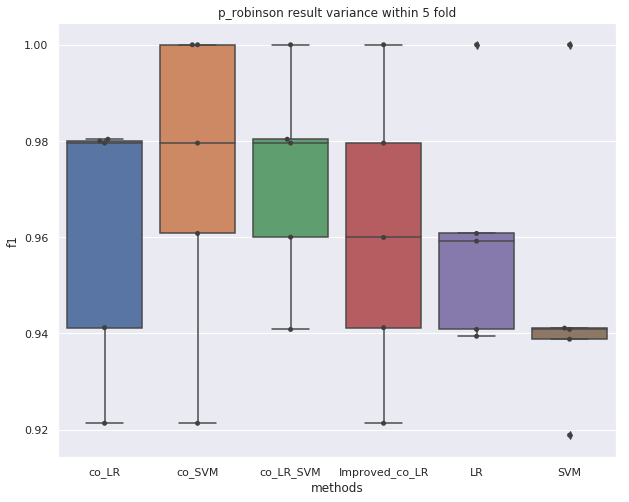

co_LR  per fold iteration:  [30, 30, 30, 30, 30]


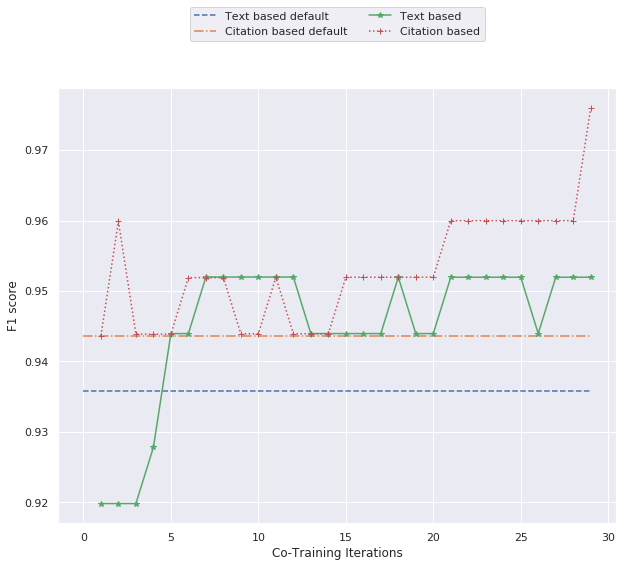

co_SVM  per fold iteration:  [30, 30, 30, 30, 30]


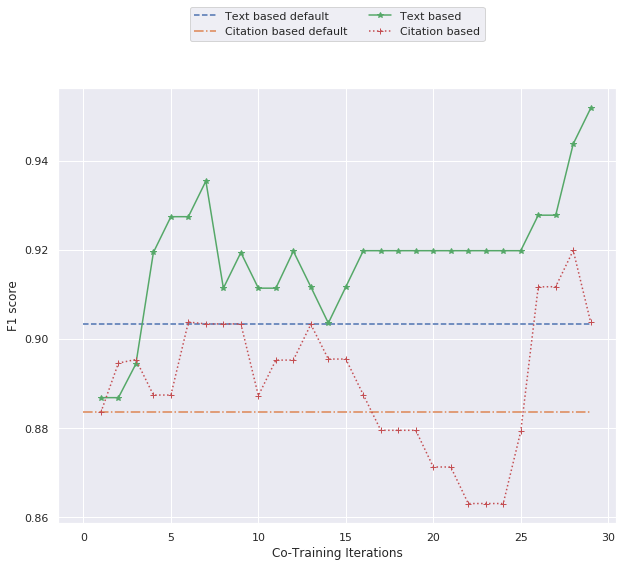

co_LR_SVM  per fold iteration:  [30, 30, 30, 30, 30]


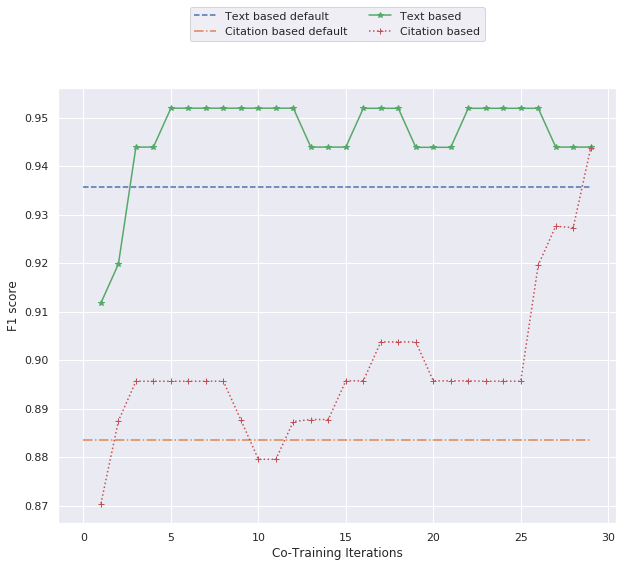

Improved_co_LR  per fold iteration:  [30, 30, 30, 30, 30]


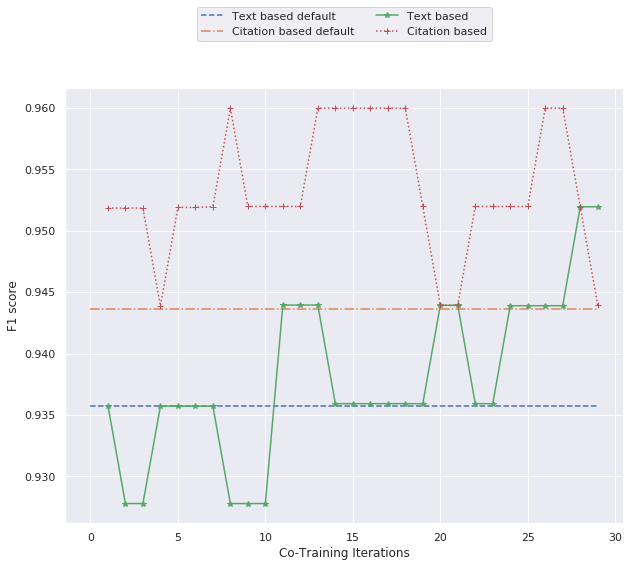

For name:  c_zou
(32, 2)
c_zou  pass
For name:  s_rana
(42, 2)
s_rana  pass
For name:  a_nunes
(61, 2)
a_nunes  pass
For name:  s_jeong
(93, 2)
s_jeong  pass
For name:  b_olsen
(213, 2)
b_olsen  pass
For name:  m_reilly
(20, 2)
m_reilly  pass
For name:  d_nguyen
(25, 2)
d_nguyen  pass
For name:  r_santos
(184, 2)
r_santos  pass
For name:  f_ferreira
(224, 2)
f_ferreira  pass
For name:  y_ng
(19, 2)
y_ng  pass
For name:  j_madsen
(69, 2)
j_madsen  pass
For name:  d_collins
(31, 2)
d_collins  pass
For name:  l_davies
(96, 2)
l_davies  pass
For name:  m_mora
(131, 2)
m_mora  pass
For name:  a_fontana
(203, 2)
a_fontana  pass
For name:  r_chen
(367, 2)
r_chen  pass
For name:  s_krause
(70, 2)
s_krause  pass
For name:  t_smith
(603, 2)
Total sample size before apply threshold:  603
Counter({'0000-0002-3650-9381': 154, '0000-0003-1673-2954': 113, '0000-0002-2120-2766': 85, '0000-0002-6279-9685': 84, '0000-0003-3528-6793': 65, '0000-0003-4453-9713': 32, '0000-0002-5197-5030': 26, '0000-0002-3

Iteration 8  h1 new:  [153, 27]  probs:  [0.977931005239486, 0.9699399903255834]
Iteration 8  h2 new:  [26, 27]  probs:  [0.9760964504438864, 0.9489689918894623]
Iteration 9  h1 new:  [155, 165]  probs:  [0.978491447088967, 0.9688315756136531]
Iteration 9  h2 new:  [155, 61]  probs:  [0.9737844782590296, 0.9465473187415395]
Iteration 10  h1 new:  [5, 156]  probs:  [0.9779577402732634, 0.9724039254729812]
Iteration 10  h2 new:  [45, 112]  probs:  [0.9722034970277506, 0.9488487118575948]
Iteration 11  h1 new:  [93, 148]  probs:  [0.9802289938711065, 0.9735624546391705]
Iteration 11  h2 new:  [119, 25]  probs:  [0.9952847287447353, 0.9601288253036389]
Iteration 12  h1 new:  [130, 87]  probs:  [0.9797745237736399, 0.9766141954536857]
Iteration 12  h2 new:  [107, 17]  probs:  [0.9951343292476899, 0.954193474521579]
Iteration 13  h1 new:  [53, 36]  probs:  [0.9798206004745822, 0.9722624339956875]
Iteration 13  h2 new:  [46, 106]  probs:  [0.9960258600999056, 0.9577721407340576]
Iteration 14 

In [ ]:
import numpy as np
import collections
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import f1_score, accuracy_score
from sklearn.decomposition import PCA

# fix random seed for reproducibility
np.random.seed(1)

# loop through all files in directory add name to name list
fileDir = "../Data/"+Dataset+"/canopies_labeled/"
listfiles = os.listdir(fileDir)

init_labeled_size = 10

co_lr_diff_embedding_result = collections.defaultdict(list)

#---------------- load different embeddings for view one ---------------#
for select_emb in pp_text:
    # read embeddings
    print("Load text embedding: ", select_emb)
    viewone_text_emb = com_func.read_text_embedding(emb_type=select_emb, training_size = "140k")
    print("Load citation embedding: ", pp_citation)
    viewtwo_citation_embedding = com_func.read_citation_embedding_sorted(emb_type = pp_citation, labeled_only = True)
    # print(viewone_text_emb[0])
    # print(viewtwo_citation_embedding[0])
    
    threshold_change_all_method_f1s = collections.defaultdict(list)
    # -------------- different threshold (step by 10) -----------------------#
    for step_threshold in range(threshold_lower, threshold_upper, 10):
        plot_save_path = "../../plot/co_train_detail_plots/threshold="+str(step_threshold)+"/V1="+select_emb+"_V2="+pp_citation+"/"
        threshold_change_all_method_f1s["threshold"].append(step_threshold)
        # collect statistic to output
        statistic_detail = collections.defaultdict(list)
        total_selected_group = 0
        selected_binary_case_group = 0

        # ------- different name group in all name group --------------------#
        for file in listfiles:
            # group name
            temp = file.split("_")
            name = str(temp[1]+"_"+temp[-1])
            print("For name: ",name)
            # read label (pid : author ORCID) from file
            data = com_func.read_pid_aid(fileDir+file)
            labeled_mask = data["authorID"] != "-1"
            labeled_data = data[labeled_mask]
            print(labeled_data.shape)
            # ---------------- collect all labeled sample -------------------- #
            # ---------------- if use all samples as negative --------------- #
            all_labeled_samples = labeled_data["paperID"].tolist()
            authorCounter = com_func.select_productive_groups(labeled_data=labeled_data, 
                                                              threshold=threshold_select_name_group)
            ''' 
            Case 1: no author under this name have written more than threshold number of papers, dataset not used
            Case 2: only one author under this name written more than threshold number of papers, dataset not used
            Case 3: 2 or more author under this name written more than threshold number of papers, dataset used
            '''
            if(len(authorCounter)==0) or (len(authorCounter)==1):
                print(name," pass")
            else:
                total_selected_group+= 1
                '''
                Case 1: All papers under name group is used. We include authors written less than threshold of paper,
                        and treat it as negative class. This will be OVR.(Not used)
                Case 2: All papers under name group is used. We include authors written less than threshold of paper,
                        and perform muti-class classification (Not used)
                Case 3: Only Include author with more than threshold number of paper and perform muti-class classification (Not used)
                Case 5: Only Include author with more than threshold number of paper and perform OVR(used)
                Case 4: Only Include author with more than threshold number of paper and only select binary case(used)
                '''
                if apply_threshold_to_name_group_samples == True:
                    # ---------- only use sample pass threshold ------- #
                    #-------- only select authors in name group are very productive (more than threshold)---------#
                    labeled_data, author_list, _= com_func.only_select_productive_authors(labeled_data, step_threshold)
                    # ----------------- if use filtered samples as negative  --------- #
                    filtered_all_labeled_samples = labeled_data["paperID"].tolist()
                else:
                    # ----------- use all sample in name group --------- #
                    author_list = com_func.productive_authors_list(labeled_data, step_threshold)
                    print(name, " name group sample size: ",labeled_data.shape)
                # -------------- extract all samples for name group -------------- #
                # for each name group
                # read in labeled data
                labeled_viewone_text = com_func.extract_sorted_embedding(viewone_text_emb, labeled_data["paperID"])
                print(labeled_viewone_text.shape)
                labeled_viewtwo_citation = com_func.extract_sorted_embedding(viewtwo_citation_embedding, labeled_data["paperID"])
                print(labeled_viewtwo_citation.shape)
                print("Labeled: ",len(labeled_viewone_text), " : ", len(labeled_viewtwo_citation))
                # ---------------- shuffle the data ----------------- #
                labeled_data = labeled_data.sample(frac=1).reset_index(drop=True)
                # ------------------ alignment and fill missing data with 0 ---------------------- #
                labeled_viewone_text = pd.merge(labeled_data, labeled_viewone_text, left_on="paperID", right_on = [0], how = "left")
                labeled_viewtwo_citation = pd.merge(labeled_data, labeled_viewtwo_citation, left_on="paperID", right_on = [0], how = "left")
                labeled_viewtwo_citation.fillna(0, inplace=True)
                unique_labels = labeled_viewone_text.authorID.unique()
                map_dict = {}
                for idx, unique_label in enumerate(unique_labels):
                    map_dict[unique_label] = name+"_"+str(idx)
                true_label = labeled_viewone_text["authorID"].replace(map_dict)
                
                print(labeled_viewone_text.shape)
                print(labeled_viewtwo_citation.shape)
                '''
                only work on binary case, ignored multi-class case
                We need to check whether the name group only contain binary case or not
                '''
                if len(author_list) == 2:
                    #if name in ["p_robinson","t_smith","d_richardson","y_wang","w_lee","k_becker"]:
                    #   print(name, " Pass for error checking")
                    #    continue
                    selected_binary_case_group +=1
                    print(name + " is binary case")
                    viewone_text_final = labeled_viewone_text.drop(["paperID", "authorID", 0], axis=1)
                    viewtwo_citation_final = labeled_viewtwo_citation.drop(["paperID", "authorID", 0], axis=1)
                    
                    ''' Apply different algorithm:
                    Part 1: Basic supervised algorithm 
                    Part 2: Basic co-training algorithm 
                    Part 3: 2 clf co-training 
                    Part 4: Improved co-training algorithm (Self-proposed with all different improvement)
                    '''
                    # -------------------- part 1 ------------------------- #
                    LR_clf = LogisticRegression(solver= "liblinear")
                    SVM_clf = SVC(gamma="auto", kernel='linear')
                    # -------------------- part 2 ------------------------- #
                    initial_cotrain_parameters = {"p":1,"n":1,"k":30}
                    co_LR_clf = Co_training_clf(clf1=LogisticRegression(solver= "liblinear"),**initial_cotrain_parameters)
                    ''' For co-training with SVM
                    Case 1: Using Scikit-learn where we set probability=True
                    Case 1 details: Scikit-learn uses LibSVM internally, and this in turn uses Platt scaling
                    Platt scaling requires first training the SVM as usual, then optimizing parameter 
                    vectors A and B such that: P(y|X) = 1 / (1 + exp(A * f(X) + B))
                    where f(X) is the signed distance of a sample from the hyperplane
                    (scikit-learn's decision_function method).
                    Case 2: Using decision_function to get signed distance of sample from the hyperplane, calculate proba
                    Case 2 details: use sigmoid (binary)/ softmax (muti-class) for calculate probability based on 
                    signed distance of sample from the hyperplane. Then follow same step as case 1. The result is relatively
                    bad
                    '''
                    # ----------- Case 1 Using Scikit-learn where we set probability=True ------ #
                    co_SVM_clf = Co_training_clf(clf1=SVC(gamma="auto", kernel='linear',probability=True),**initial_cotrain_parameters)
                    # ------- Case 2 Using decision_function get distance, calculate proba------ #
                    #co_svm_clf = Co_training_clf(clf1=SVC(gamma="auto", kernel='linear'),**initial_cotrain_parameters)
                    #co_train_clfs = [(co_svm_clf,"co_train_SVM")]
                    # -------------------- part 3 ------------------------- #
                    # two different clf with basic co-training
                    co_LR_SVM_clf = Co_training_clf(clf1 = LogisticRegression(solver= "liblinear"),
                                                    clf2 = SVC(gamma="auto", kernel='linear',probability=True),
                                                    **initial_cotrain_parameters)
                    # -------------------- part 4 ------------------------- #
                    improved_cotrain_parameters = {"sl_total":2,"k":30}
                    improved_co_LR = Improved_co_training_clf(clf1 = LogisticRegression(solver= "liblinear"), 
                                                              **improved_cotrain_parameters)
                    # -------------------- train together ----------------- #
                    baseline_clfs = [(LR_clf,"LR"),(SVM_clf,"SVM")]
                    final_co_train_clfs = [(co_LR_clf,"co_LR"), (co_SVM_clf,"co_SVM"),
                                           (co_LR_SVM_clf, "co_LR_SVM"), (improved_co_LR, "Improved_co_LR")]
                    final_f1_score, cv_per_fold_status= k_fold_cv_all_algorithm(dv1=viewone_text_final,
                                                                                dv2=viewtwo_citation_final,
                                                                                label=true_label,
                                                                                init_labeled_size=init_labeled_size,
                                                                                muti_view_clf=final_co_train_clfs,
                                                                                combined_clf=baseline_clfs,
                                                                                num_fold=5,
                                                                                dataset_name=name,
                                                                                plot_save_path=plot_save_path)
                    #print(final_f1_score)
                    #print(cv_per_fold_status)
                    statistic_detail['Name'].append(name)
                    statistic_detail['Total_sample_size'].append(len(true_label))
                    statistic_detail['Train_size'].append(cv_per_fold_status[0]["train_size"])
                    statistic_detail['Unlabel_size'].append(cv_per_fold_status[0]["unlabel_size"])
                    statistic_detail['Validation_size'].append(cv_per_fold_status[0]["validation_size"])
                    statistic_detail['Test_size'].append(cv_per_fold_status[0]["test_size"])
                    for clf, clf_name in final_co_train_clfs:
                        statistic_detail[clf_name+'_total_self_labeled'].append(cv_per_fold_status[0][clf_name+"_total_self_labeled"])
                    
                    for clf_name, clf_f1 in final_f1_score:
                        statistic_detail[clf_name+"_f1"].append(clf_f1)
                else:
                    print(name+ " is multi-class case, ignored")

        # print(statistic_detail)
        print("Total number of selected group:",total_selected_group)
        print("Total number of selected binary group:",selected_binary_case_group)
        print("Total number of selected muti-class group:",(total_selected_group-selected_binary_case_group))
        # write evaluation result to excel
        output = pd.DataFrame(statistic_detail)
        print(output)
        savePath = "../../result/"+Dataset+"/co_train_sample=140k/"
        filename = "(init_labeled_size="+str(init_labeled_size)+") V1="+select_emb+"_V2="+pp_citation+"_threshold="+str(step_threshold)+".csv"
        com_func.write_csv_df(savePath, filename, output)
        print("v1:",select_emb," v2:",pp_citation, "threshold",step_threshold," Done")
        
        '''Save result with respect to threshold change'''
        threshold_change_all_method_f1s['Name'].append(statistic_detail['Name'])
        for col in output.columns: 
            if "f1" in col:
                threshold_change_all_method_f1s[col].append(statistic_detail[col])

    co_lr_diff_embedding_result["v1:"+select_emb+" v2:"+pp_citation].append(threshold_change_all_method_f1s)


In [ ]:
#         # --------------- plot overall result f1 variance --------------- #
#         all_per_fold_f1_score_variance_plot = pd.DataFrame(all_per_fold_f1_score_variance)
#         ax = sns.boxplot(x="author", y="f1", data=all_per_fold_f1_score_variance_plot)
#         ax = sns.swarmplot(x="author", y="f1", data=all_per_fold_f1_score_variance_plot, color=".25")
#         plt.savefig(plot_save_path+"all_result_variance.png", dpi=300)
#         # plt.show()